# Week 10: Machine Learning Force Fields

## Review on Classical Force Fields

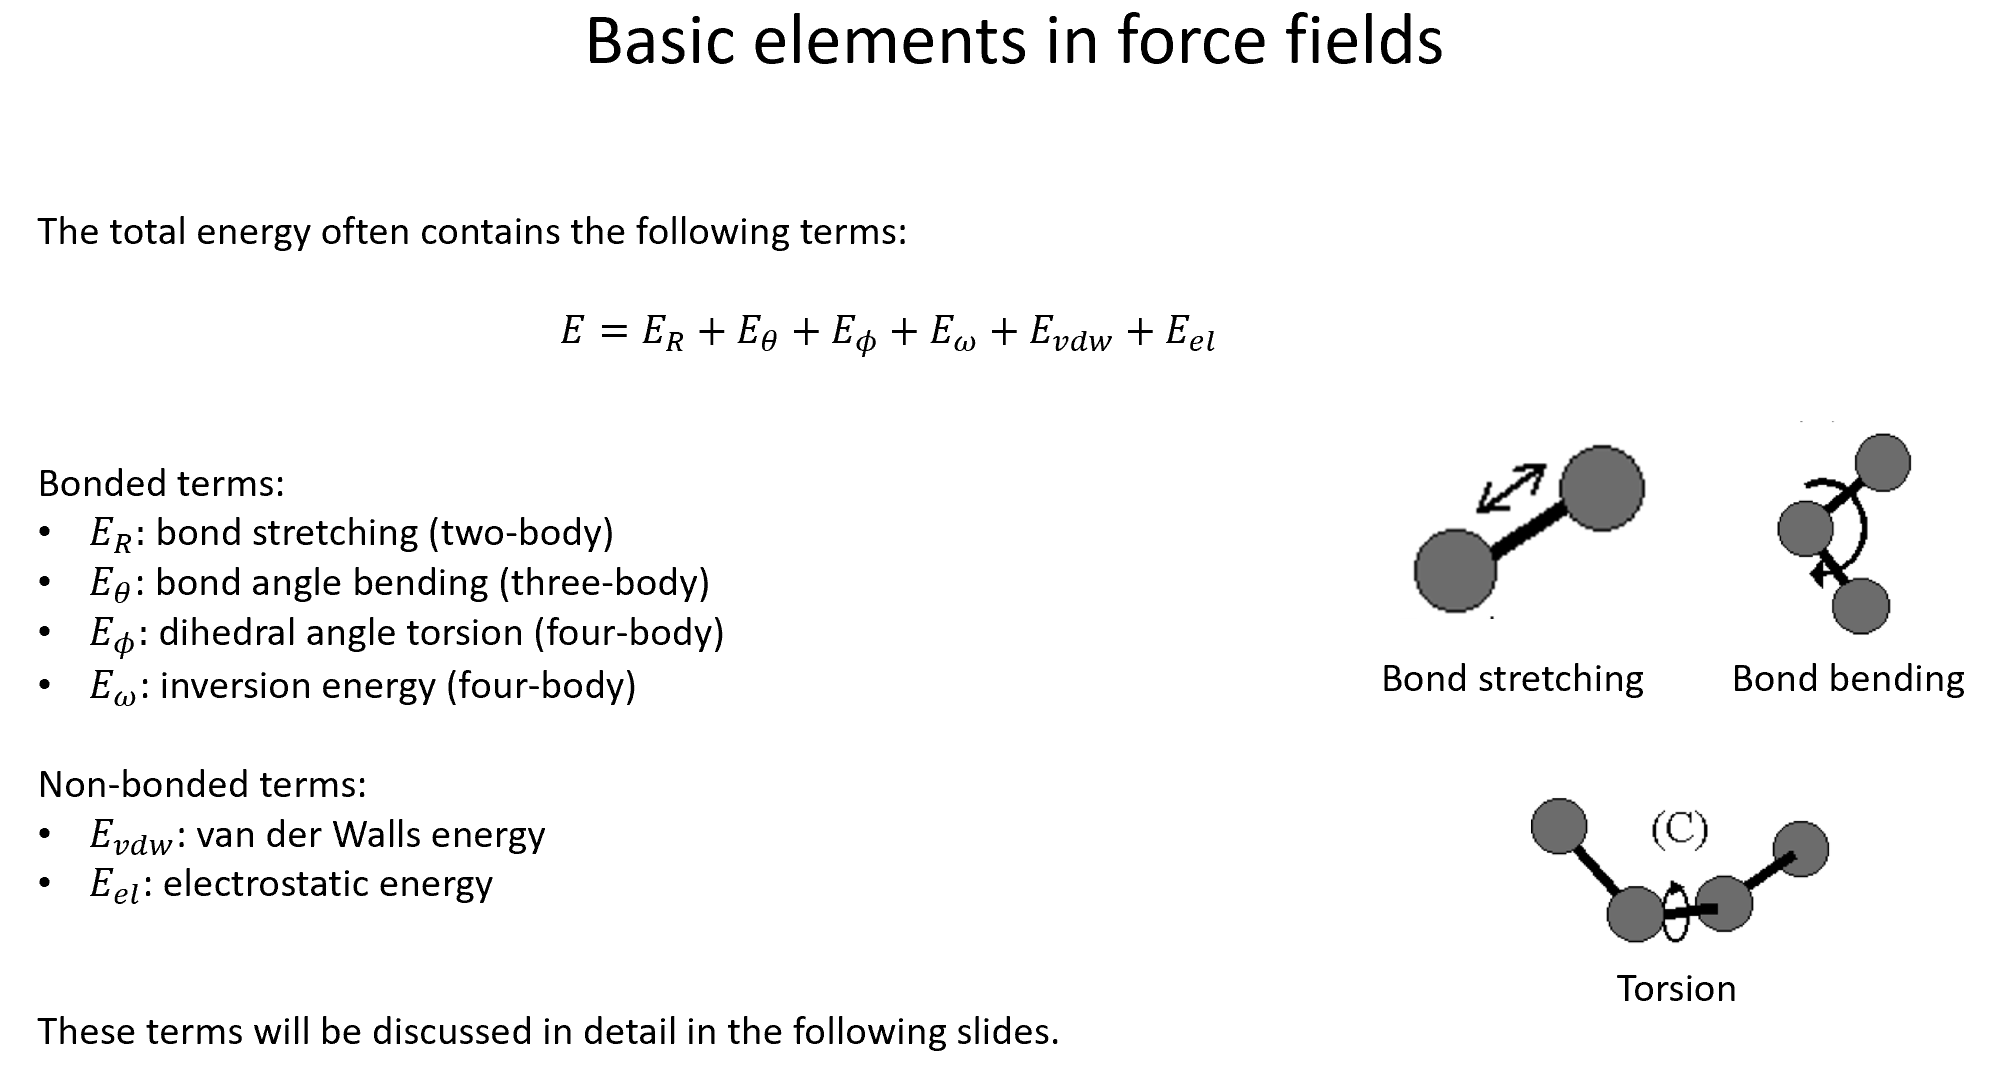

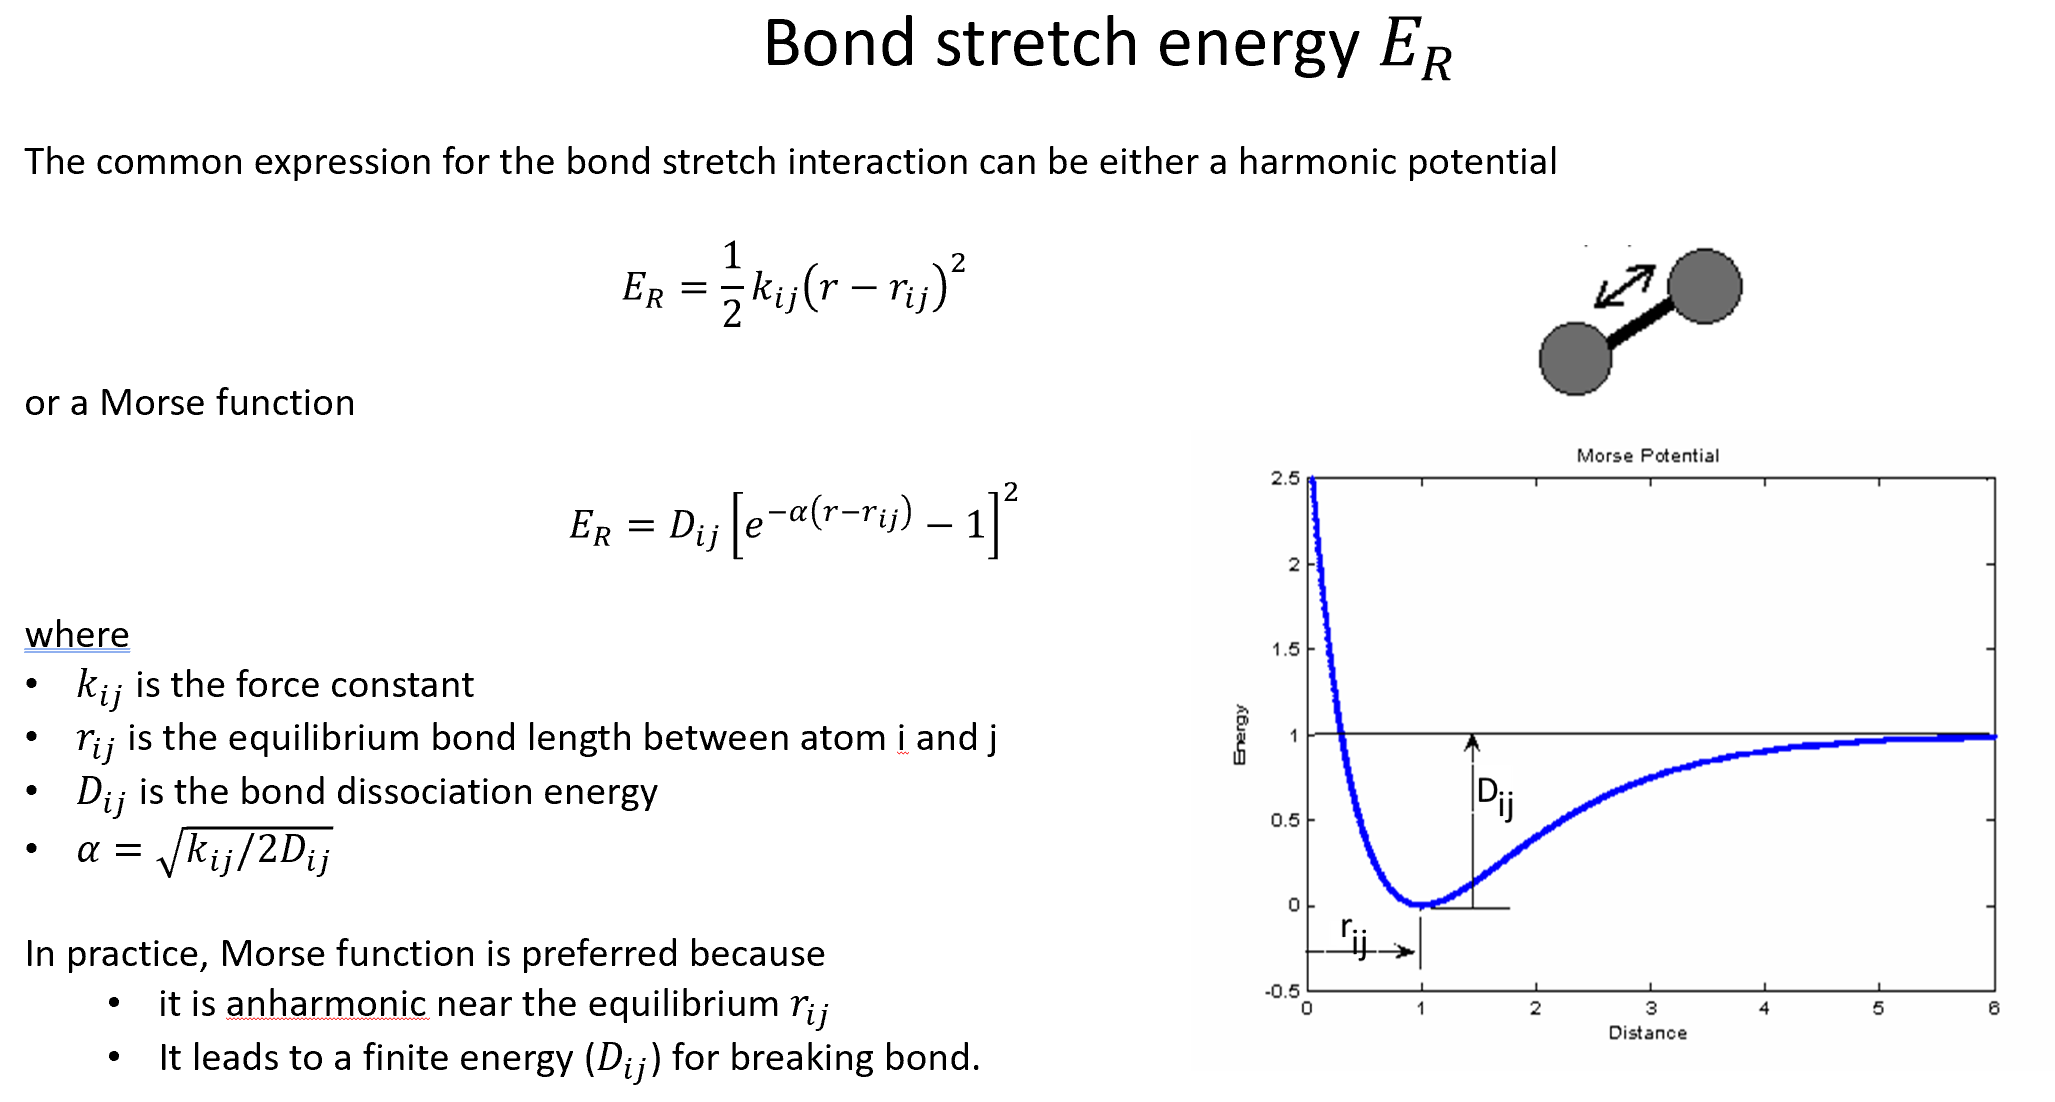

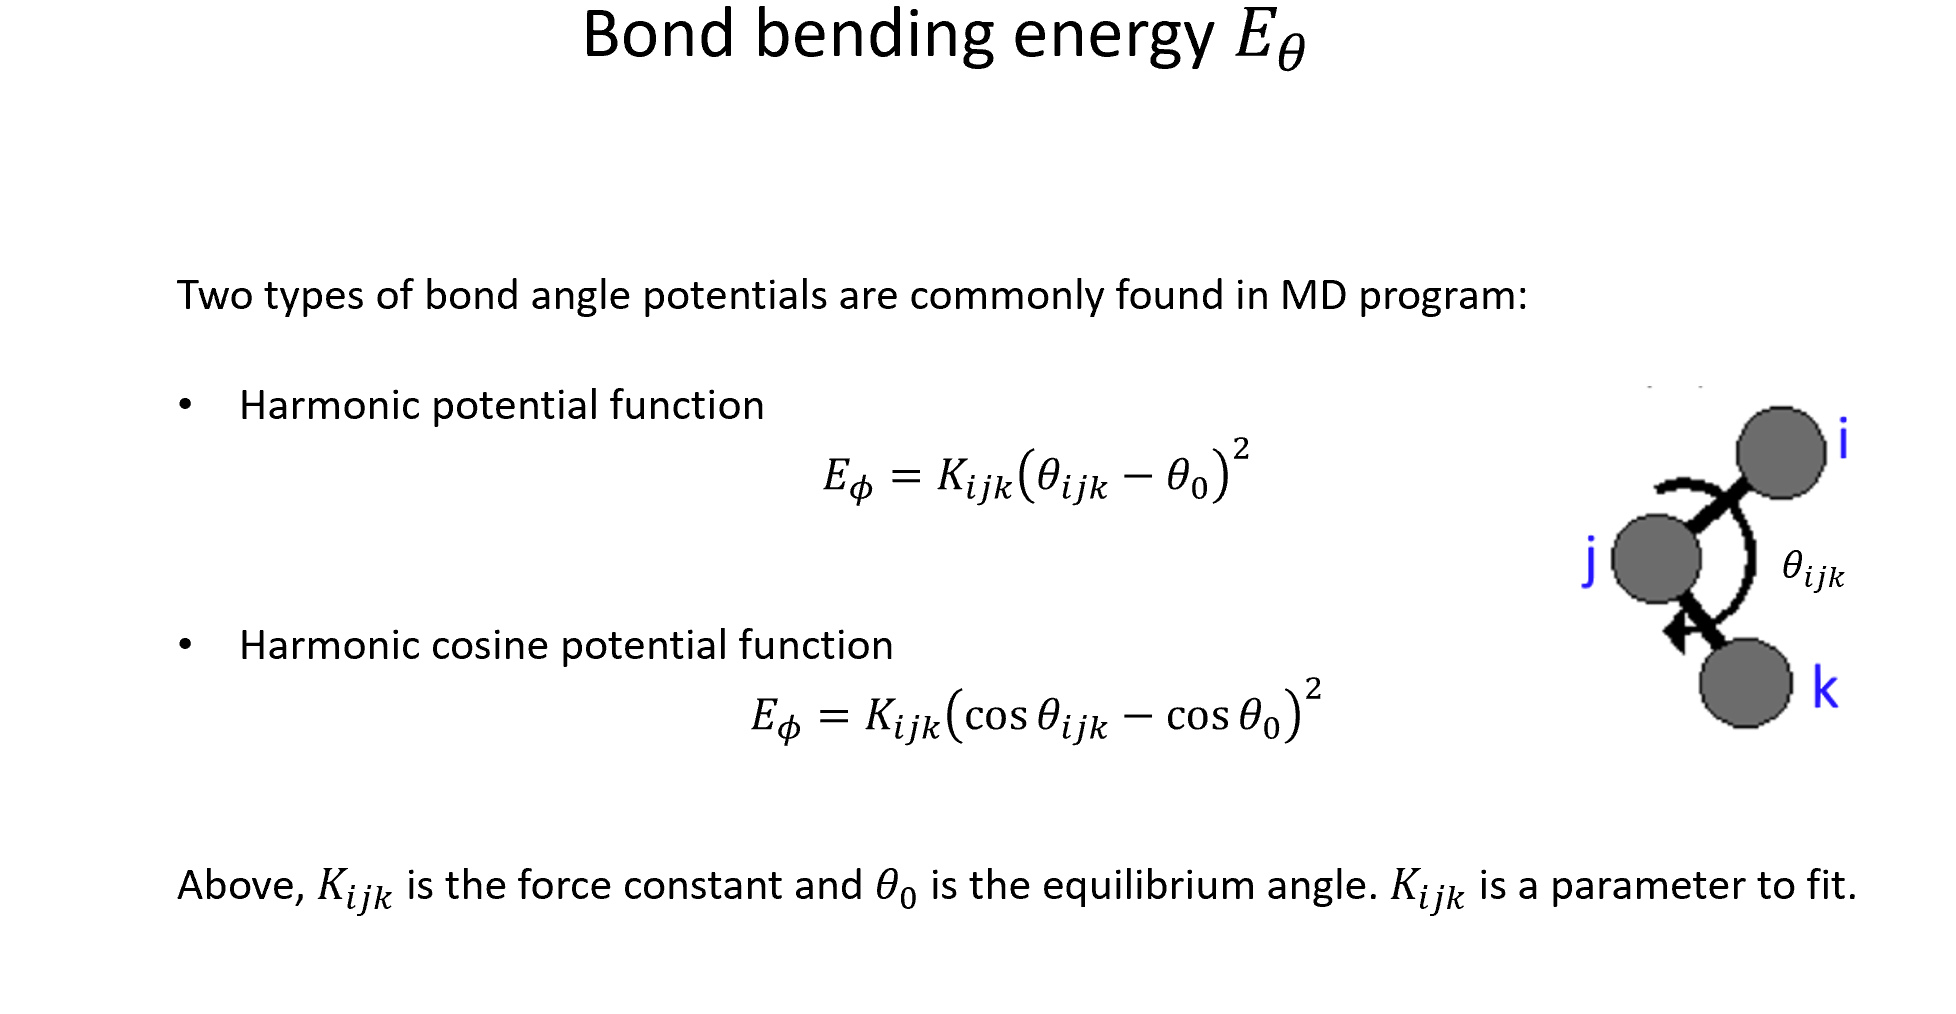

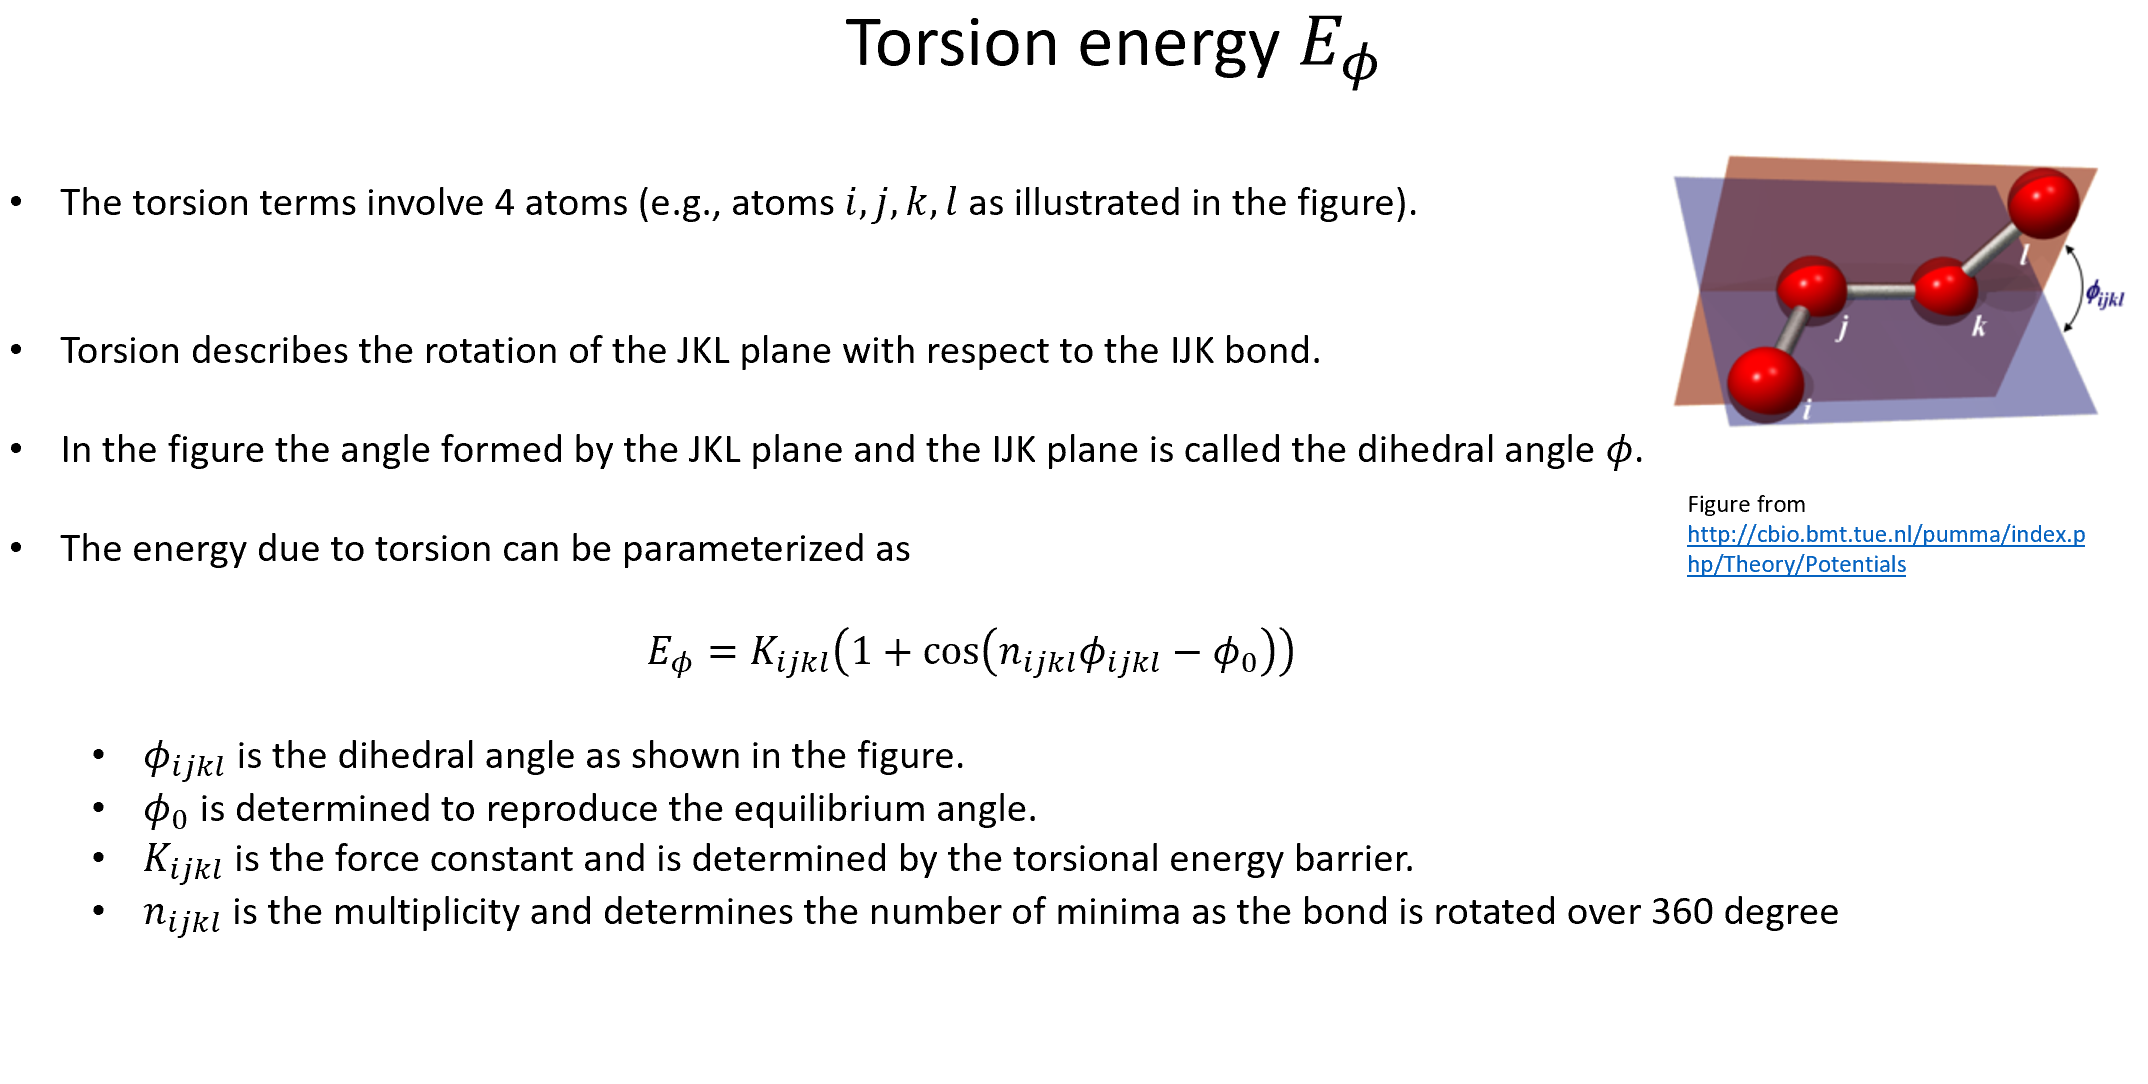

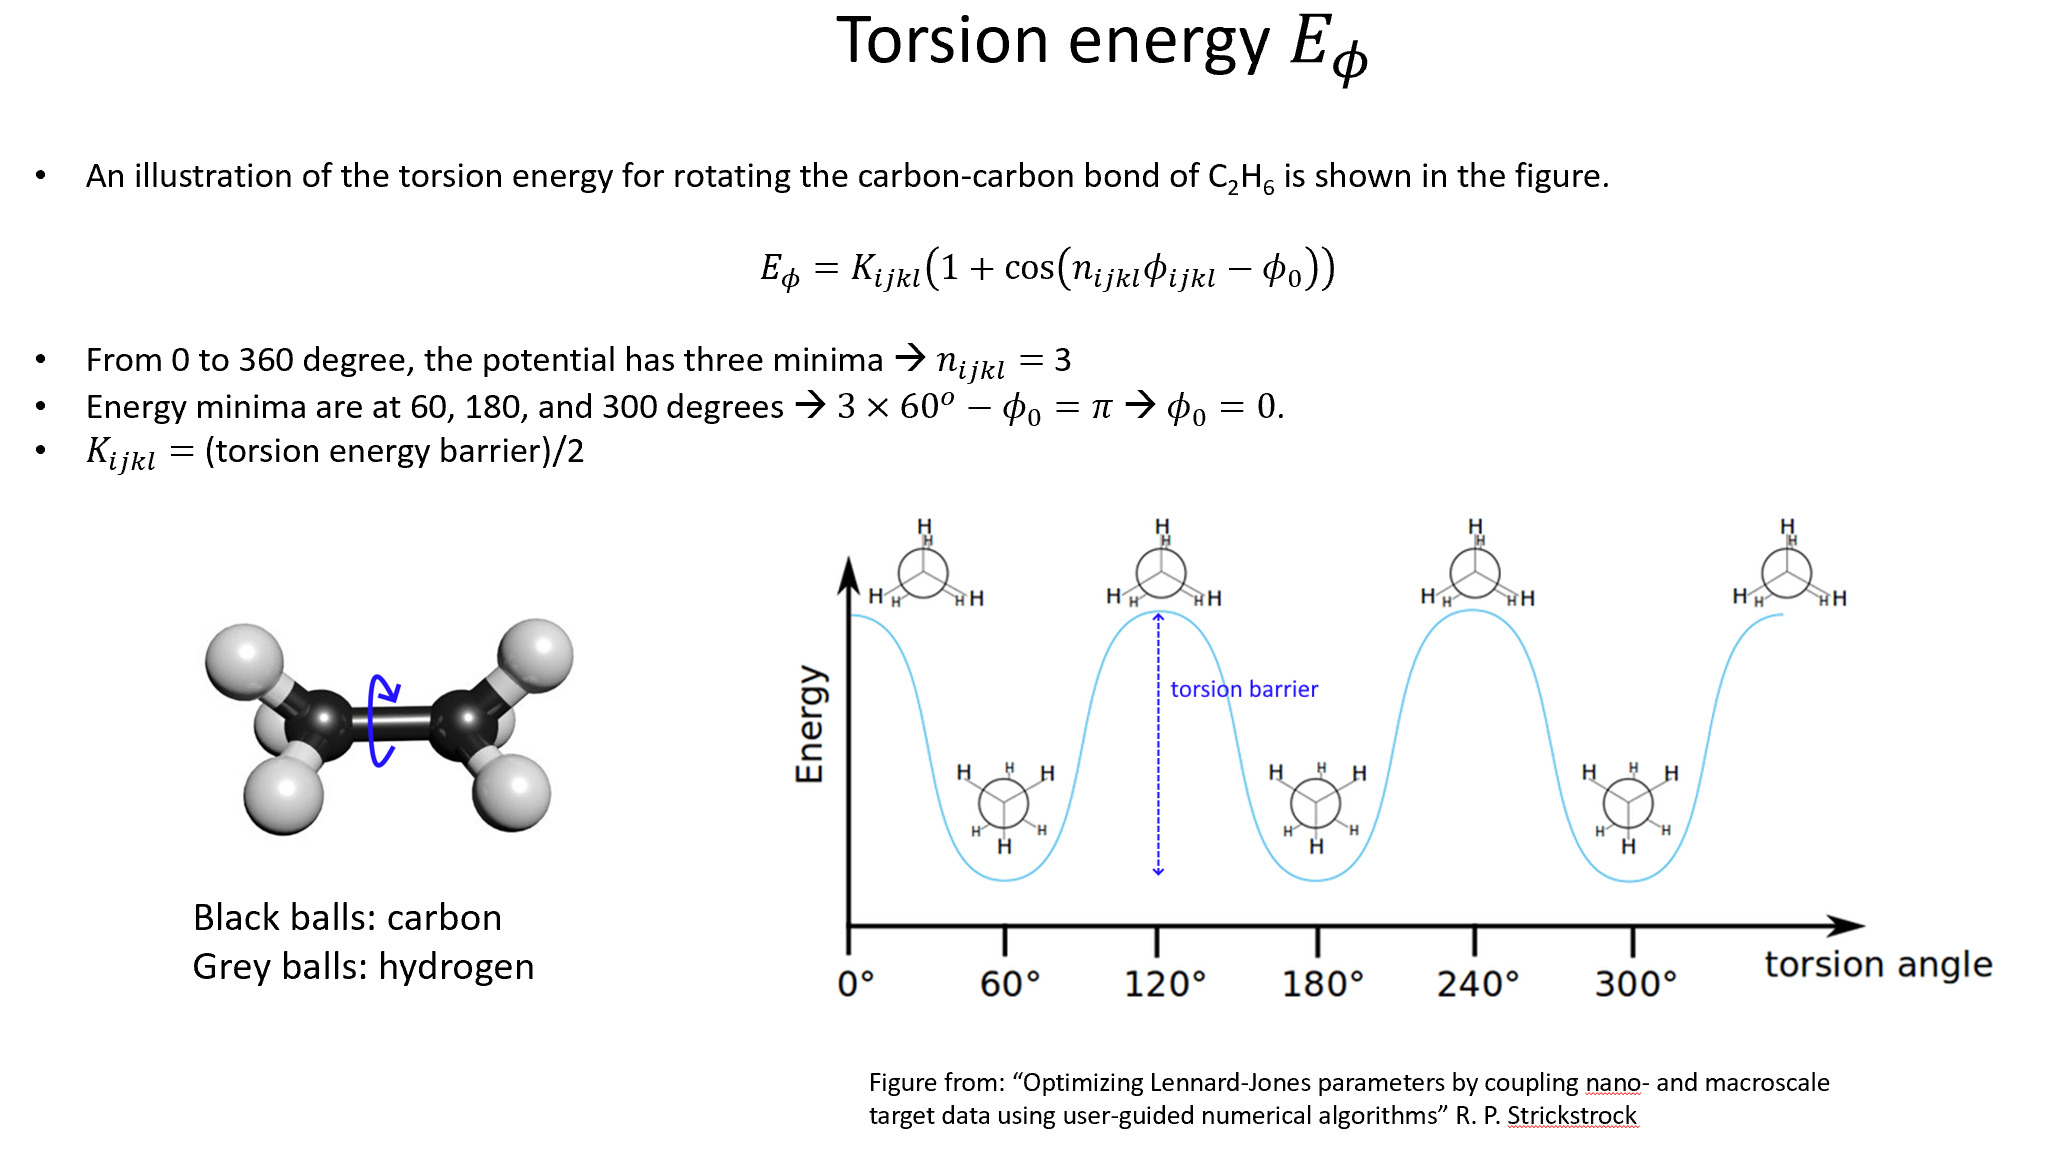

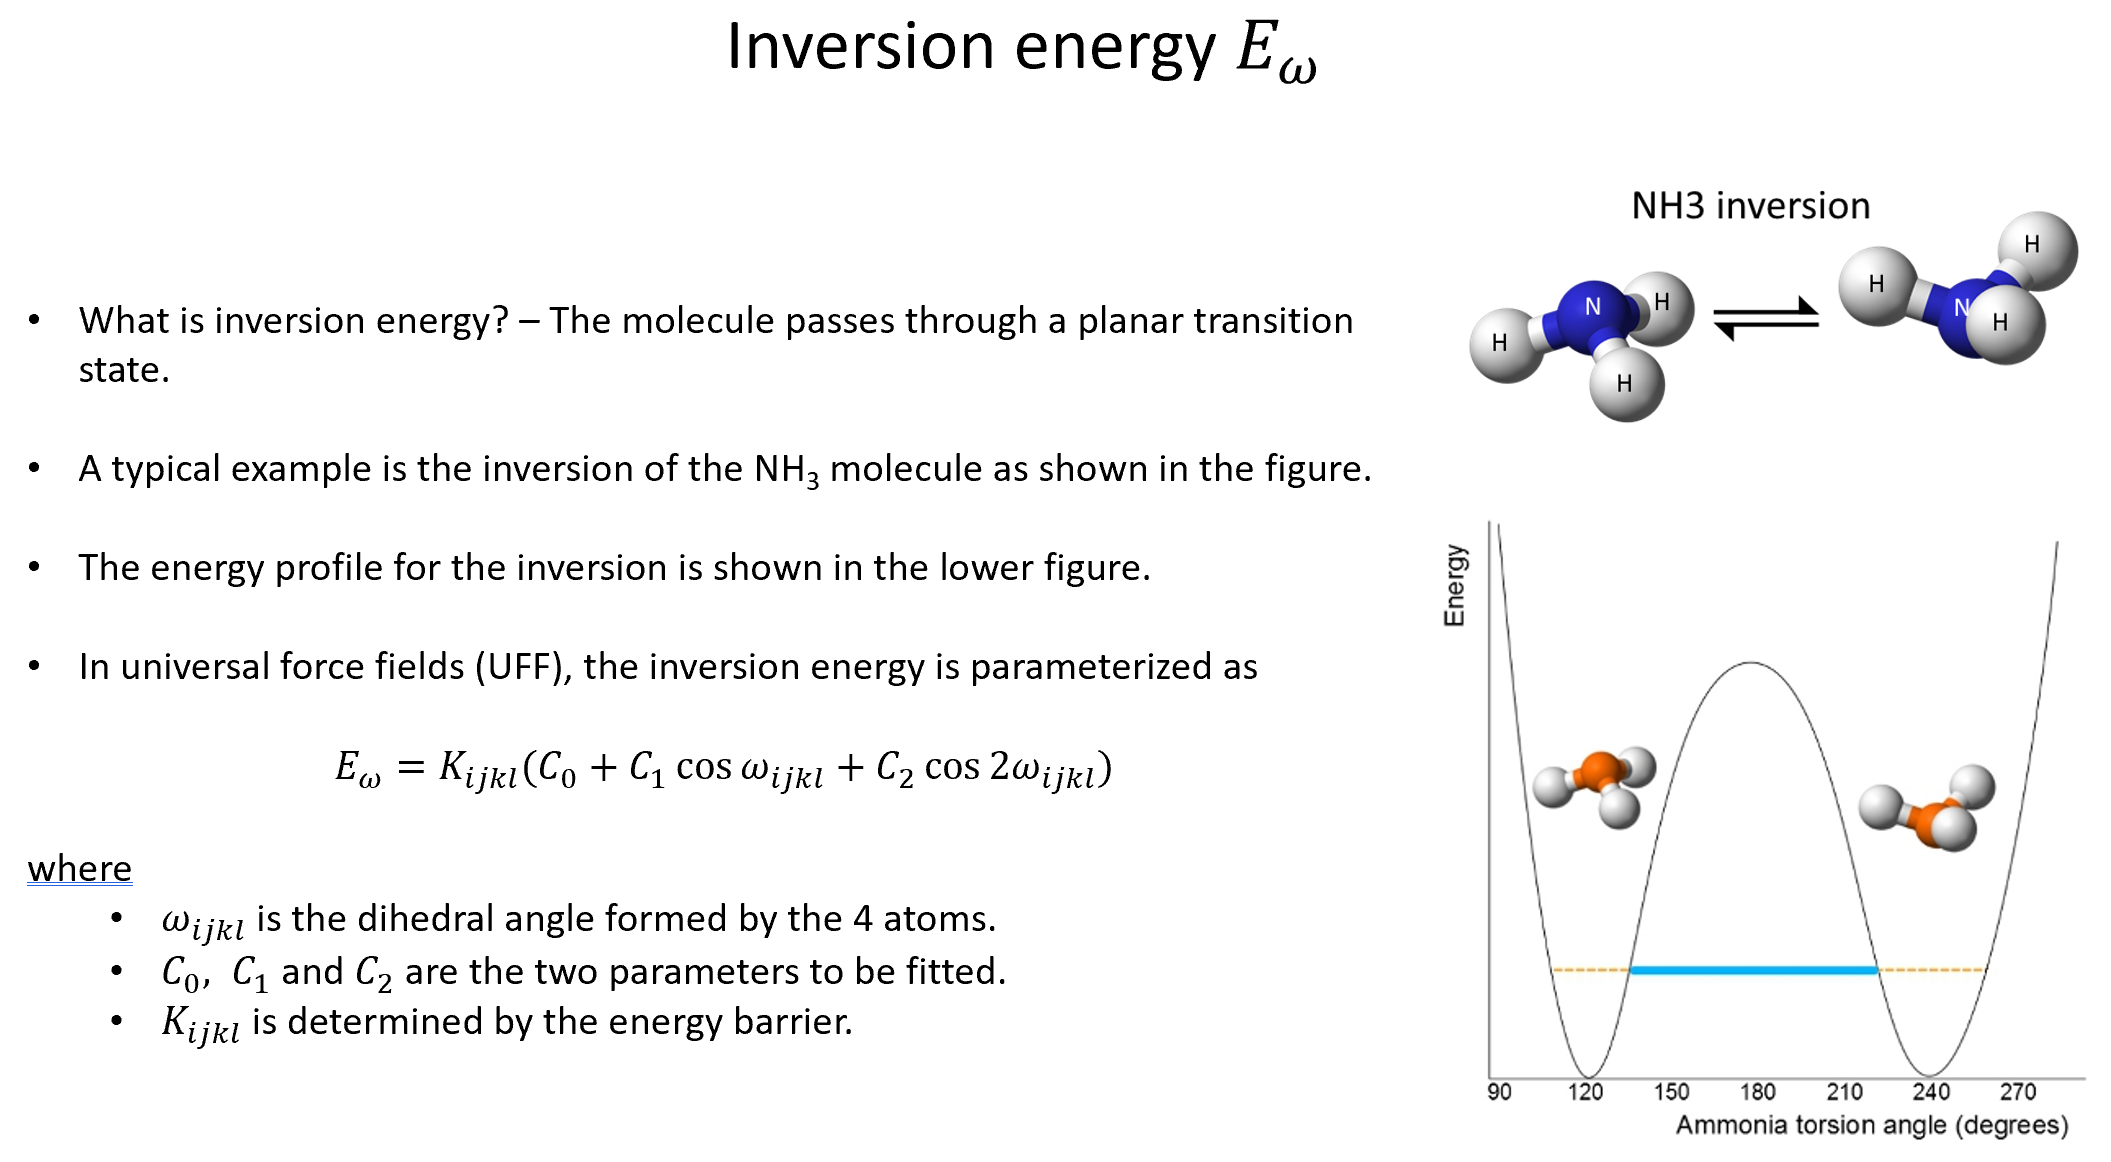

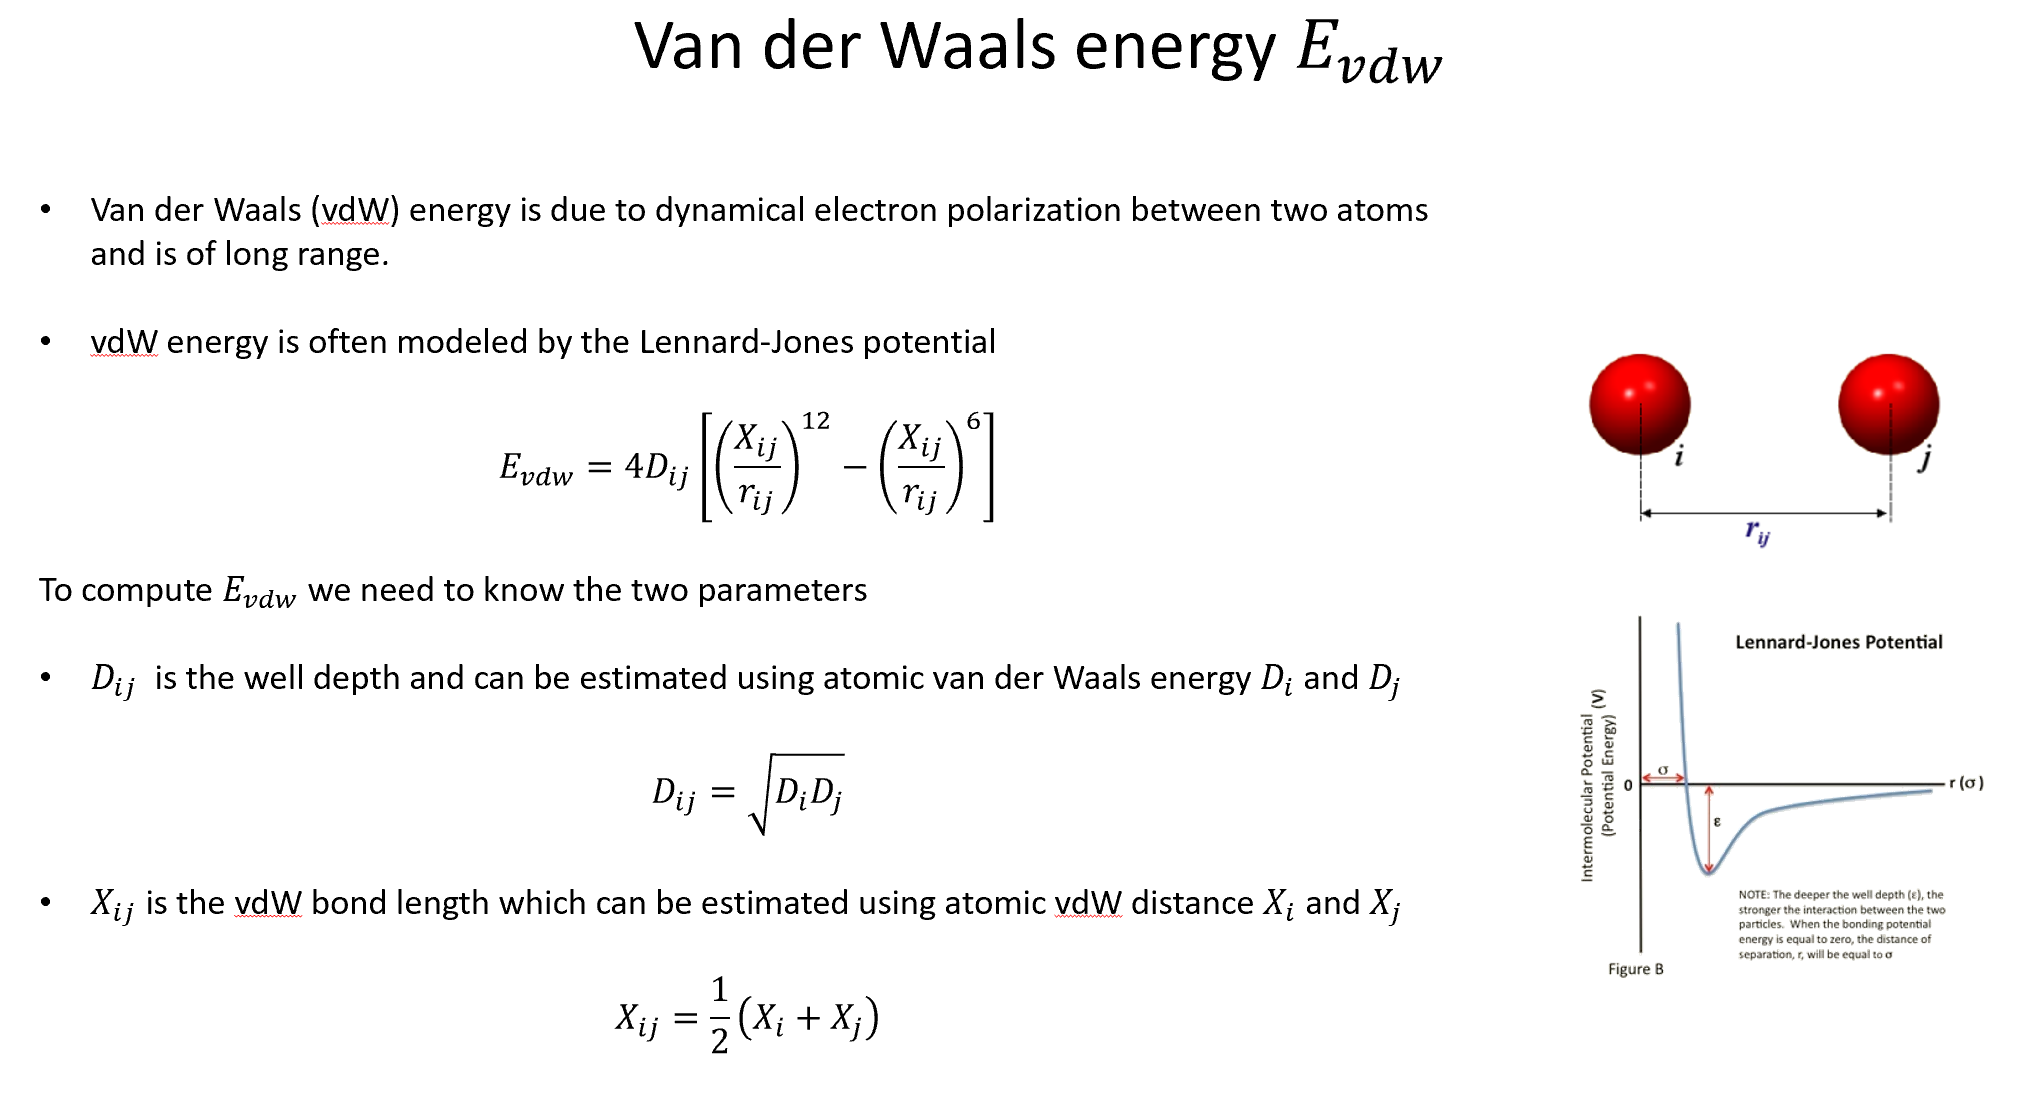

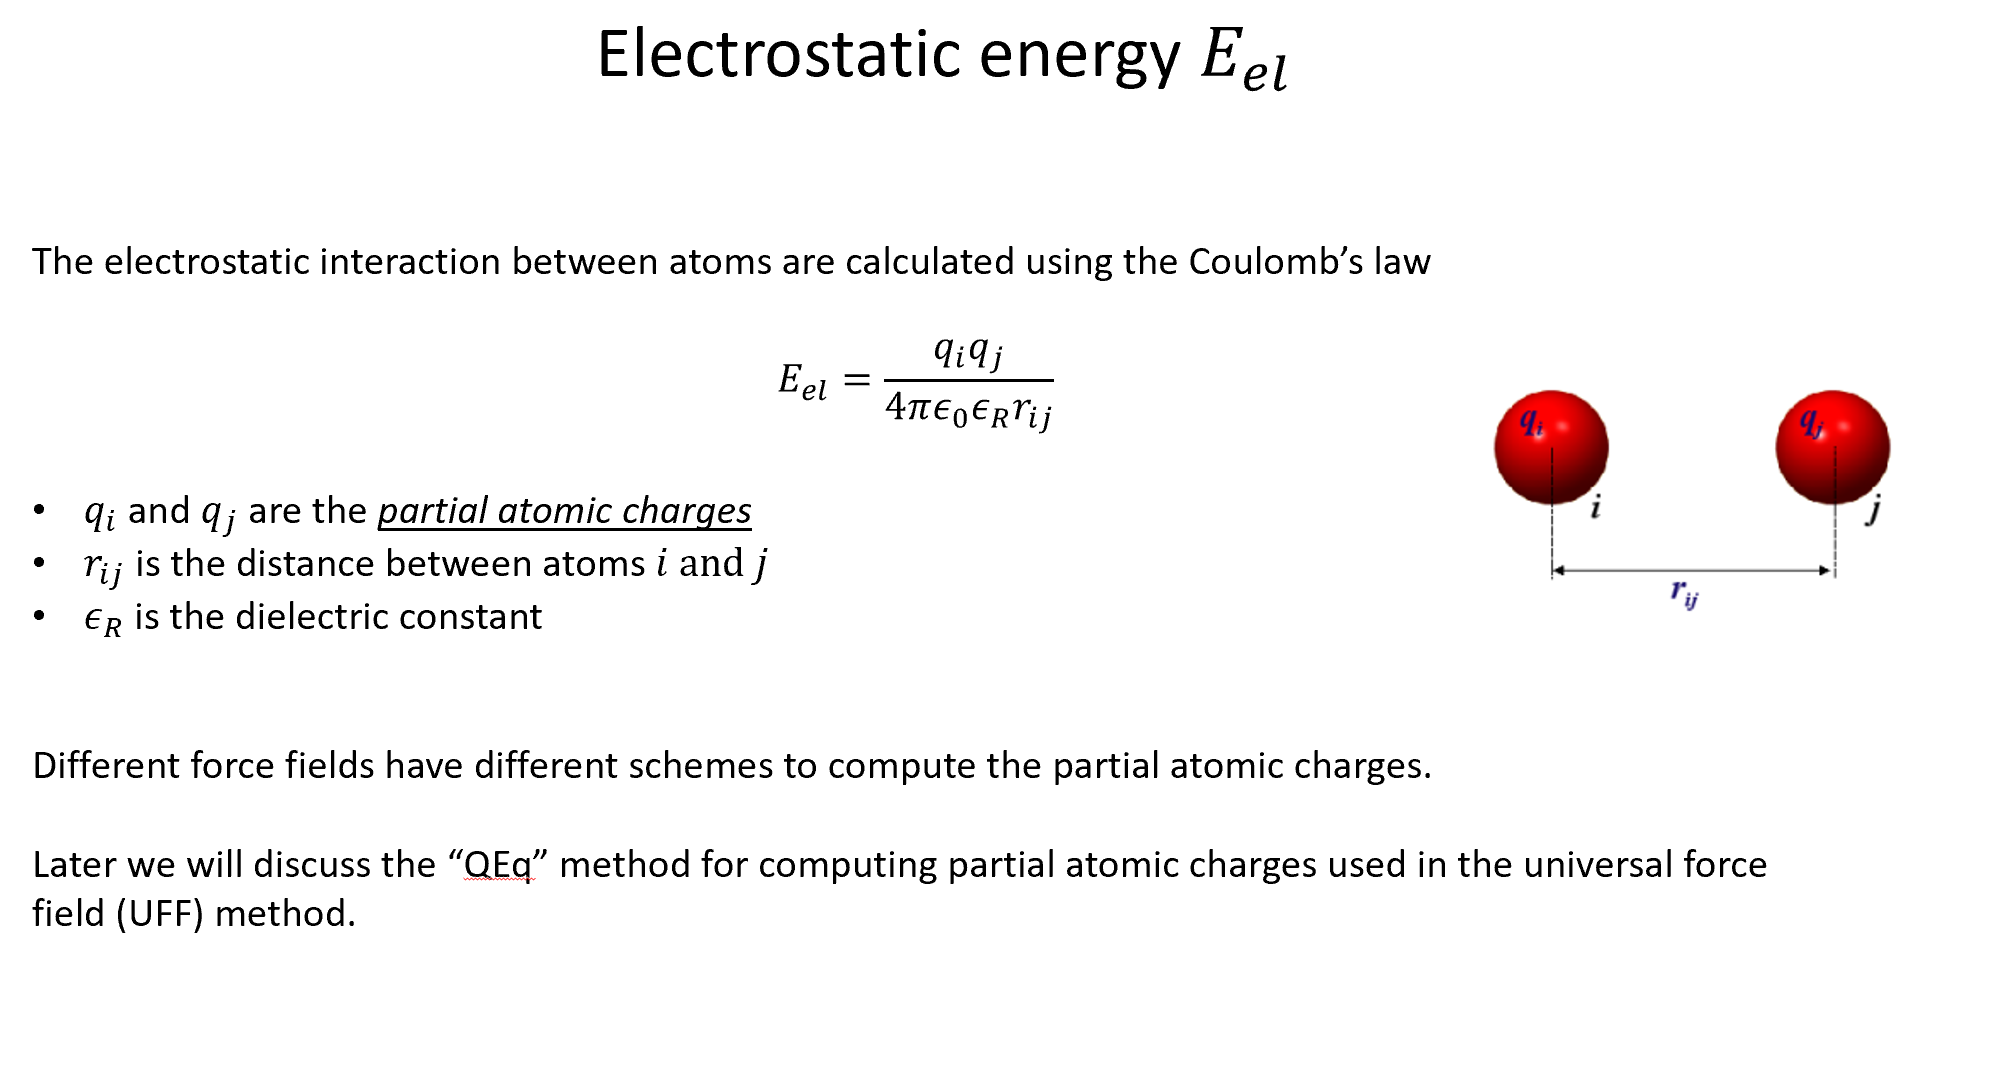

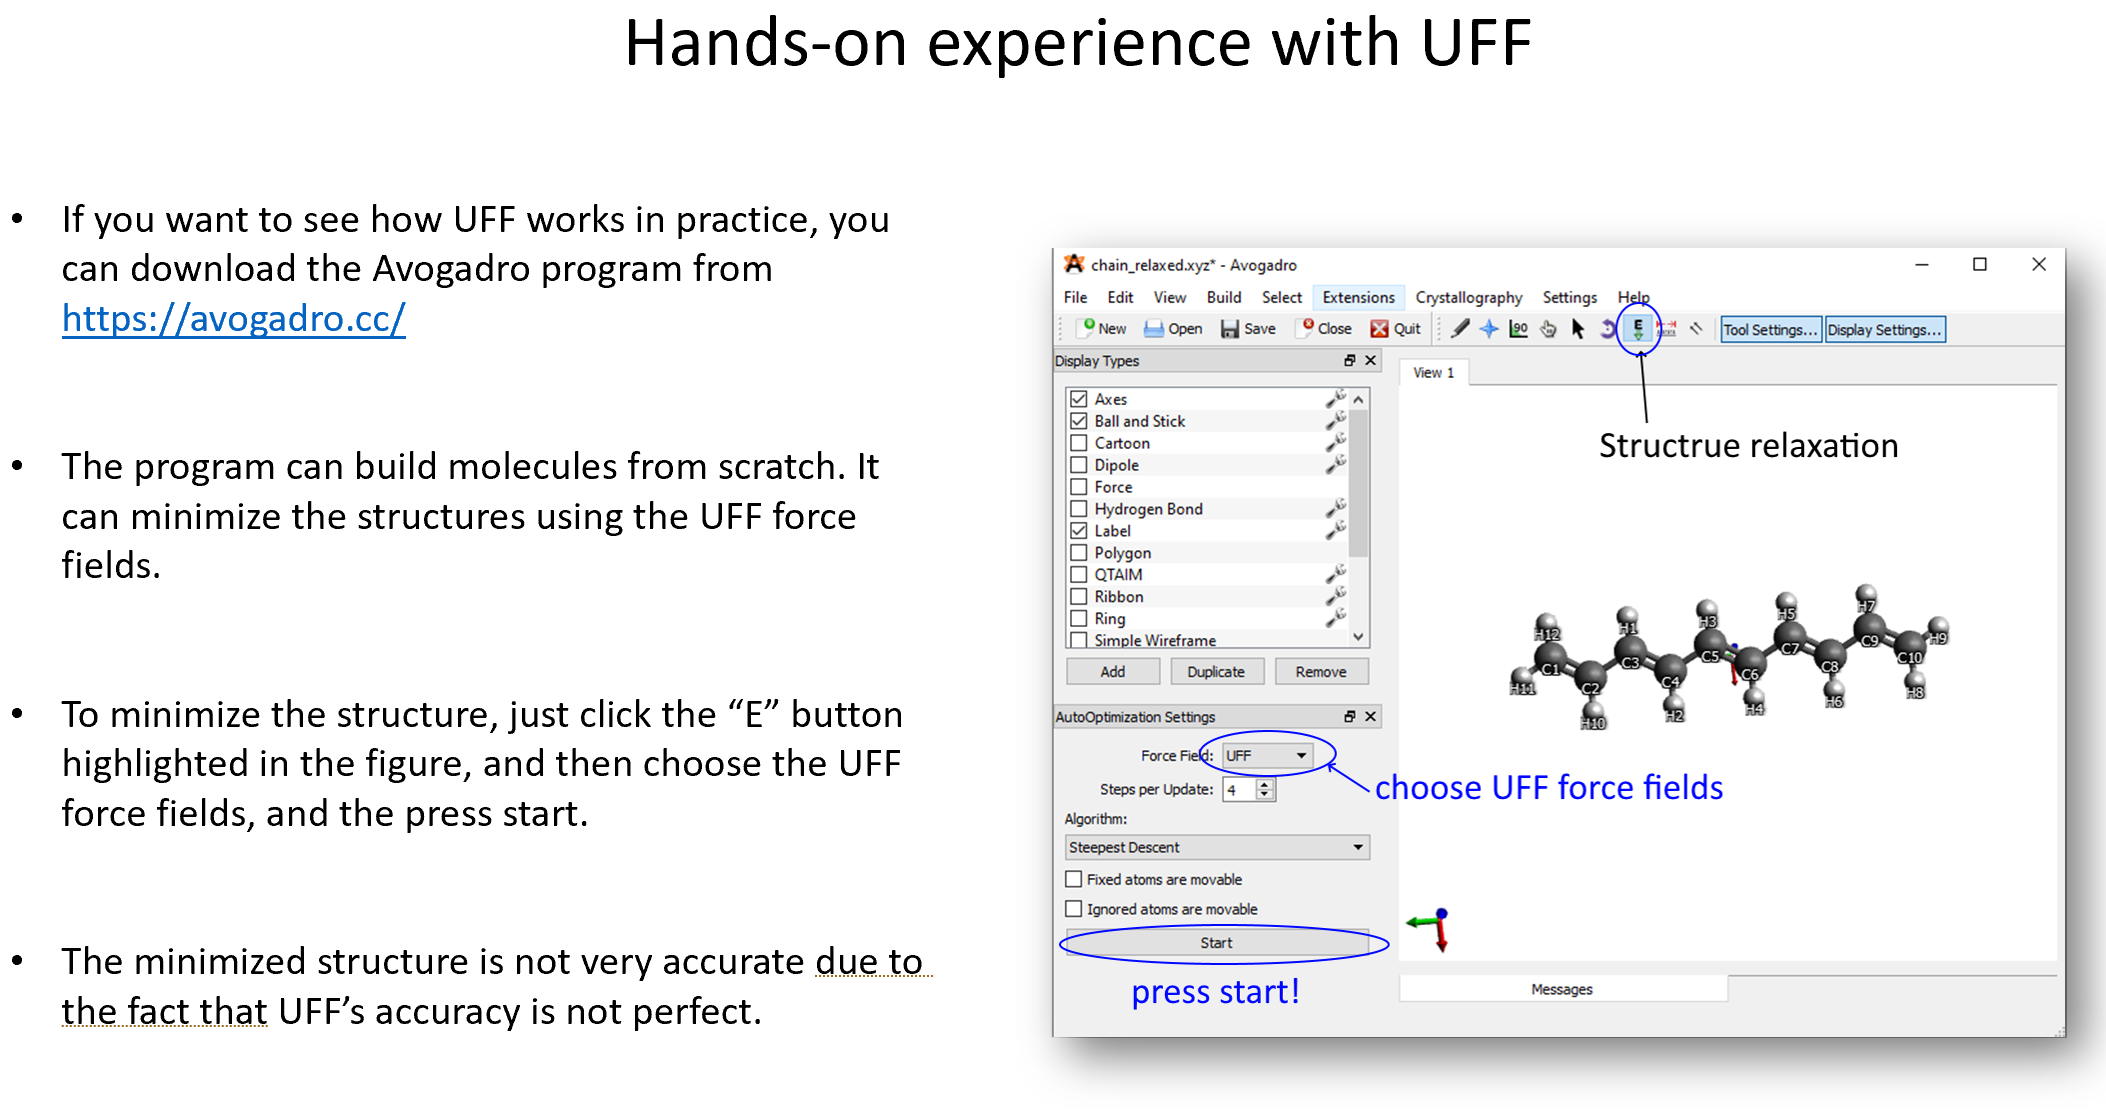

# High-dimensional neural-network potentials (NNPs)

Alternatively, we may prefer to delegate the construction of the potential to a neural network. In this way, we don't have to do a search for the potential's terms and its parameters. We'll have to train a neural network instead.

This training requires a wealth of molecular geometries and their respective energies. Our hope is that by providing ample high-quality chemical data, the NNP will be able to make energy predictions on par with the level of theory of the original data. Furthermore, predicting the properties of a sample using a neural network is fundamentally a linear algebra computation: this is a much simpler and faster procedure than calculating the molecule's energy with a quantum chemistry package.

While performing the training is necessary before any predictions can be made, this slow and expensive process only needs to be performed _once_.

## Transforming geometries into NN inputs
Once we have selected an NN with a given architecture and trained it, the NN will be ready to perform any amount of predictions, so long as the new samples remain compatible with it. In particular, the amount of input properties must be the same for all the new samples.

This suggests the xyz-coordinates of the molecule are ill-suited to be the neural network's inputs: molecules with more or less atoms than those molecules that the neural network was trained with, would have poorer predictions or be outright incompatible with the NNP.

Furthermore, reordering the atoms in the input would effectively change the NN inputs, and thus the output would too change. The molecular energy would remain invariant to this permutation, though. Further problems arise if the molecule were to be rotated or translated.

In short, we need to encode the molecular structure in such a way that the inputs remain invariant to the operations that leave the energy unchanged. Behler explains (see section *IV. SYMMETRY FUNCTIONS* of  https://doi.org/10.1063/1.3553717) that a suitable molecular descriptor meets these criteria:
* *Is continuous*,

* *Is differentiable*: if we seek a model capable of calculating the atomic forces, the molecular descriptors must be differentiable.

* Remains the same size irrespectively of:
    * the amount of atoms in the sample: this ensures the NNP will be compatible with molecules of different sizes.
    * the amount of bonds for each atom: if we wish to perform a MD experiment with the NNP, we can expect some bonds to break and some other to form as the experiment goes on. It's preferrable that the NNP is compatible with this phenomenon.

* Is invariant to translations, rotations, and reordering the atoms in the xyz file.
As explained above, the energy is invariant to these changes. Yet, if the absolute value of the inputs changes, then we can only expect the output (the atomic/molecular energy) to change too.

* And finally, decays towards 0 for larger interatomic distances,

This is not a crucial criterion to meet, but it makes the training easier: interatomic energies also decay towards $0$ when the respective atoms are far from each other. If this behavior is intrinsic to the descriptor, then the NN will have an easier training.

## Behler-Parrinello symmetry functions

Behler and Parrinello's NNP formulation meets the descriptor criteria outlined above by transforming the molecular coordinates with a set of *symmetry functions*. The result of these functions is the input of the NNP.

For a discussion in greater detail on the BP functions, see section *IV. B.* of https://doi.org/10.1063/1.3553717 or eqs. 3-5 of https://doi.org/10.1103/PhysRevLett.98.146401. The function plots in this section were all adapted or modified from https://doi.org/10.1063/1.3553717.

There are radial and angular symmetry functions. The first kind recollects the pair-wise interactions of the atoms in a molecule; the second kind is analogous to the three-body terms in the classical potentials.

There is a core function common to all the BP symmetry functions: The cutoff function $f_{\mathrm{c}}$. For a given cutoff radius $R_{\mathrm{c}}$, this function dampens the interaction between the atoms $i$ and $j$ according to their distance:
$$
f_{\mathrm{c}} = \left\{
\begin{array}{lc}
0.5\left[ \cos\left( \frac{\pi R_{ij}}{R_{\mathrm{c}}} \right) +1 \right] & \text{ if } R_{ij} \leq R_{\mathrm{c}} \\
0 & \text{ otherwise}
\end{array}
%
\right.
$$

It looks like this:

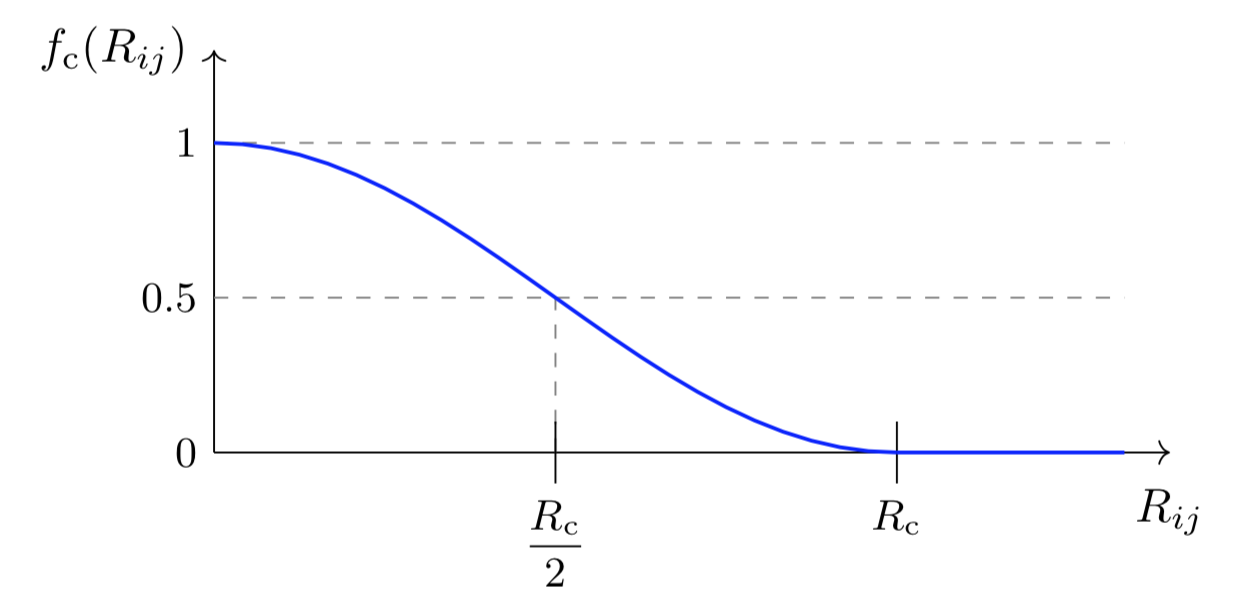

### Behler-Parrinello radial symmetry functions

These functions are evaluated separately for each atom. For the atom $i$, the selected functions are evaluated for all the possible pairs $(i,j)$.

The **first function** is simply the sum of the $f_{\text{c}}$ for all the possible atom pairs involving the atom $i$:

$$
G_i^1 = \sum_{\substack{j = 1 \\ j \neq i}}^{n_{\text{a}}} f_{\text{c}}(R_{ij})
$$

A series of $G_i^1$ with different $R_{\text{c}}$ can be used to probe the radial environment around the atom $i$.

The plot below shows the effect of $R_{\text{c}}$ in the function's width. For the rest of the radial function plots, $R_{\text{c}} = 10\ \text{angstrom}$ was chosen.

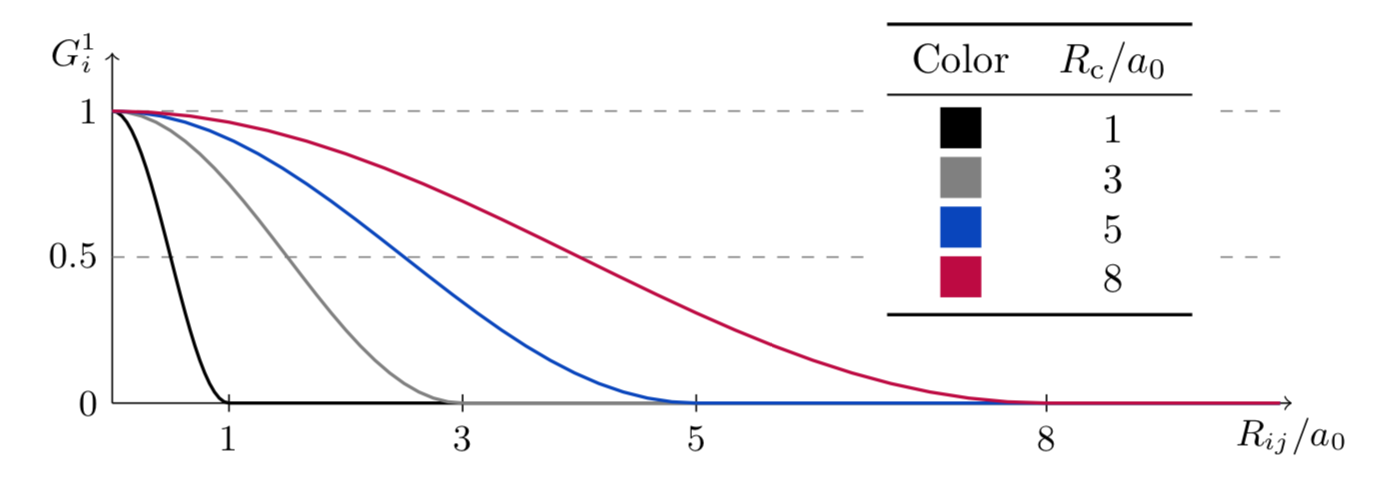

The **second function** adds a Gaussian function to the mix. The width of the function is given by $\eta$, and its maximum is located in $R_s$. A series of this function, each with a different $R_s$, can too be used to probe the environment around the atom $i$.

$$
G_i^2 = \sum_{\substack{j = 1 \\ j \neq i}}^{n_{\text{a}}} \exp[ -\eta(R_{ij} - R_{\text{s}})^2] \cdot f_{\text{c}}(R_{ij})
$$

The plot below shows the effect of different values of $\eta$; $R_s$ is set to $0$.

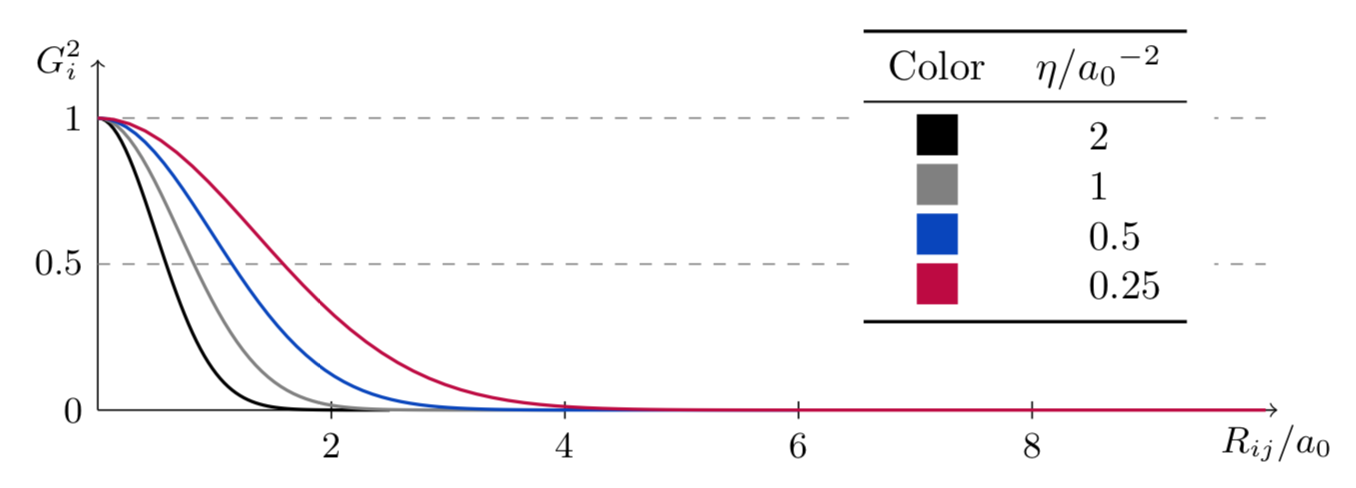

The plot below now sets $\eta = 2\ a_0^{-2}$; the effect of different $R_s$ is shown.

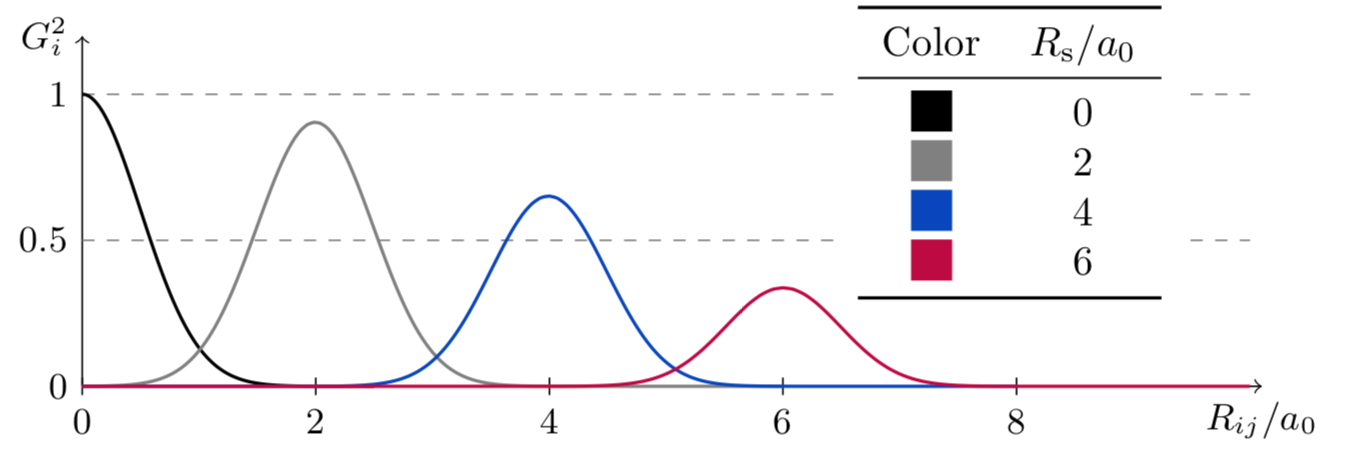

The **third function** is a dampened cosine function. Their period is modulated by the parameter $\kappa$. Unlike the previous two functions, which are $> 0 \forall i,j$, the $G_i^3$ function may have negative values. Therefore, Behler recommends to never use this function *in isolation*: terms may cancel each other and this could hide information from the NN.

That said, these functions can be used without issue in conjunction with an ensemble of the $G_i^1$ and $G_i^2$ functions.

$$
G_i^3 = \sum_{\substack{j = 1 \\ j \neq i}}^{n_{\text{a}}} \cos(\kappa R_{ij}) \cdot f_{\text{c}}(R_{ij})
$$


This plot shows the effect of $\kappa$ in the function's behavior.

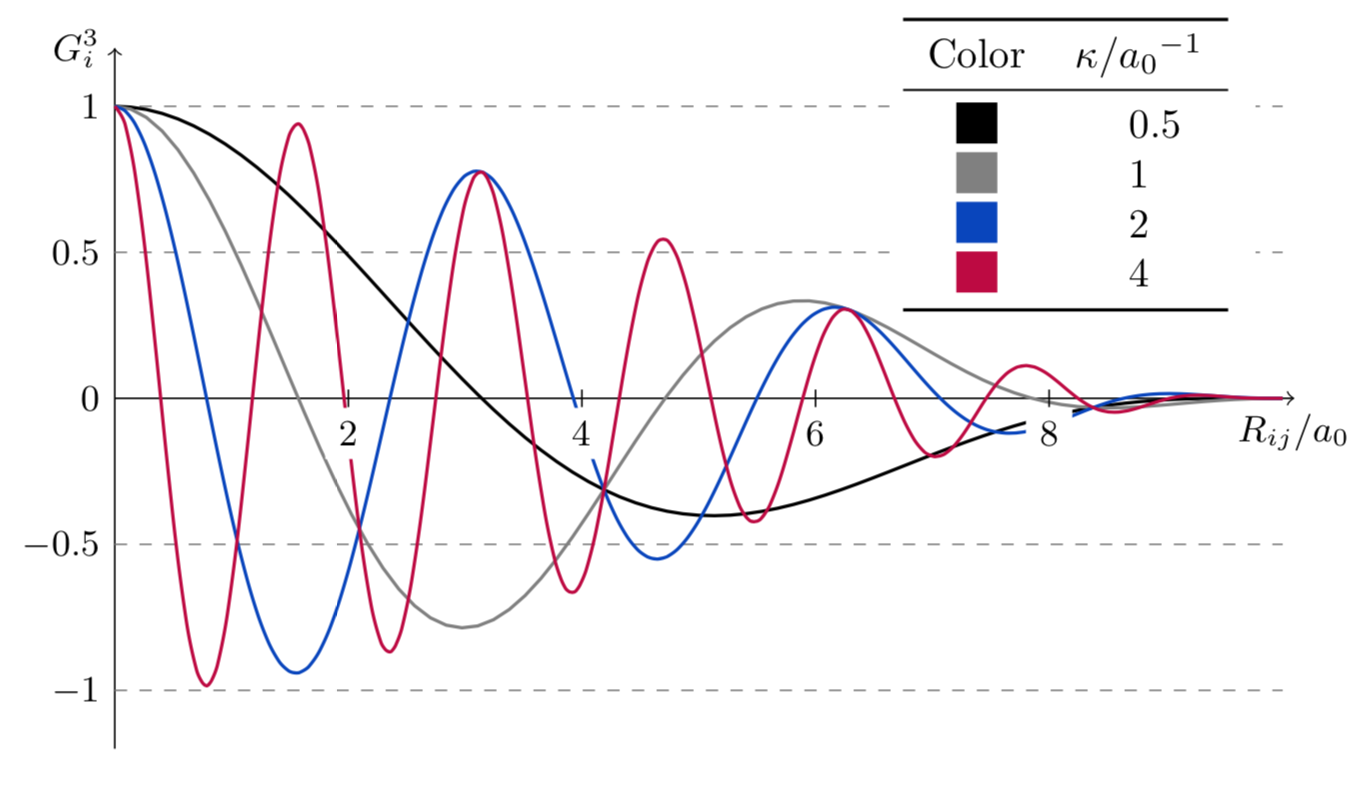

### Behler-Parrinello angular symmetry functions

These functions are evaluated separately for each atom. For the atom $i$, the selected functions are evaluated for all the possible triads $(i,j,k)$.

The angle of atom $i$ with its neighbors $j$ and $k$, denoted $\theta_{ijk}$, can be computed by
$$
\theta_{ijk} = \arccos\hspace{0.02 em} \left( \frac{\vec{R_{ij}} \cdot \vec{R_{ik}}}{R_{ij} \cdot R_{ik}} \right)
$$
where $\vec{R_{il}}$ is the vector that connects atoms $i$ and $l$; $R_{il}$ is the distance between these two atoms.

The **fourth function** is

$$
G_i^4 = 2^{1-\zeta} \sum_{\substack{j=1 \\ j \neq i}}^{n_{\text{a}}} \sum_{\begin{subarray}{l}
k=1 \\ k \neq i \\ k \neq j
\end{subarray}}^{n_{\text{a}}} (1 + \lambda \cos \theta_{ijk})^\zeta \cdot \exp[-\eta(R_{ij}^2 + R_{ik}^2 + R_{jk}^2)] \cdot f_{\text{c}}(R_{ij}) \cdot f_{\text{c}}(R_{ik}) \cdot f_{\text{c}}(R_{jk})
$$

The **fifth function** is 

$$
G_i^5 = 2^{1-\zeta} \sum_{\substack{j=1 \\ j \neq i}}^{n_{\text{a}}} \sum_{\begin{subarray}{l}
k=1 \\ k \neq i \\ k \neq j
\end{subarray}}^{n_{\text{a}}} (1 + \lambda \cos \theta_{ijk})^\zeta \cdot \exp[-\eta(R_{ij}^2 + R_{ik}^2)] \cdot f_{\text{c}}(R_{ij}) \cdot f_{\text{c}}(R_{ik})
$$

Some points on the functions:
* Both functions are still subject to symmetry: the energy of a triad of atoms with an angle of $181^\circ$ is the same as that of an equal triad with an angle of $179^\circ$. Therefore, the descriptors for both of the aforementioned triads must be equal too. This restricts the parameter $\lambda$ to $\{-1,1\}$.

* On the other hand, the parameter $\zeta$ controls how diffuse the function is.
* The angular part of both functions is the same; it's the radial parts that differ. The presence of $R_{jk}$ in $G_i^4$ makes it decay more sharply.
* An ensemble of functions with different $(\lambda,\zeta, R_{\text{c}})$ can be used to probe the radial-and-angular environment around the atom $i$.

The plots below show both $G_i^4$ and $G_i^5$. The radial parts of both were set to $1$, and thus only the angular term (it's equal for both!) is shown.

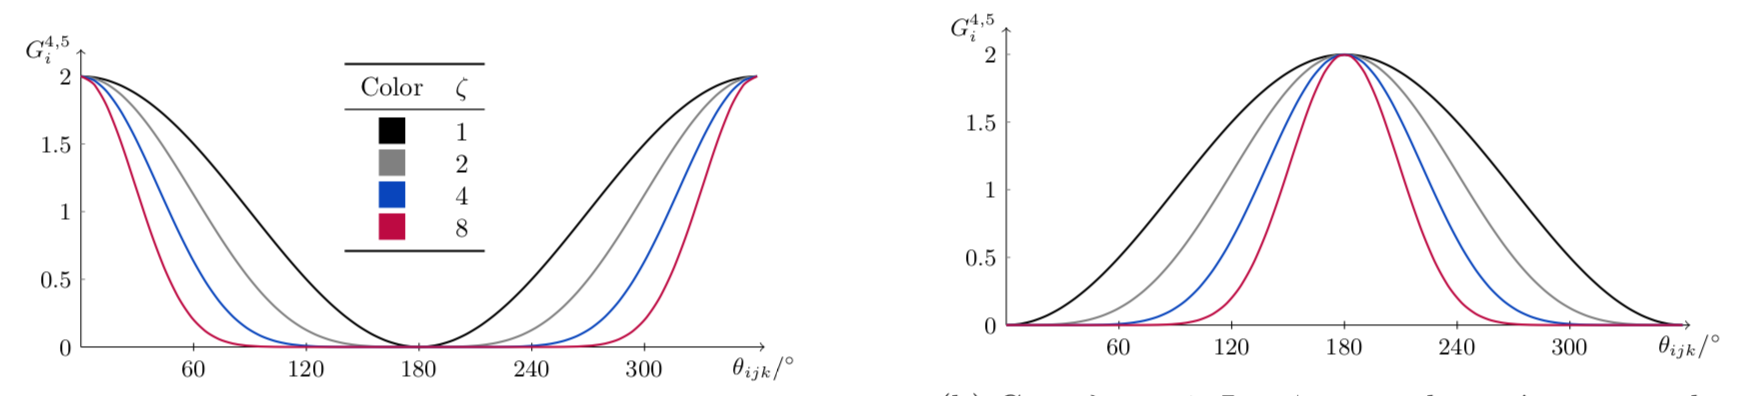

Now let's look at the behavior of these functions according to the distances $R_{ij}$ and $R_{jk}$ (they are equal in the plots below).

For this example let us consider the three kinds of carbon-carbon bonds: they are rather similar in terms of distance. As it turns out, even minute differences are enough for the function to change its behavior rather sharply.

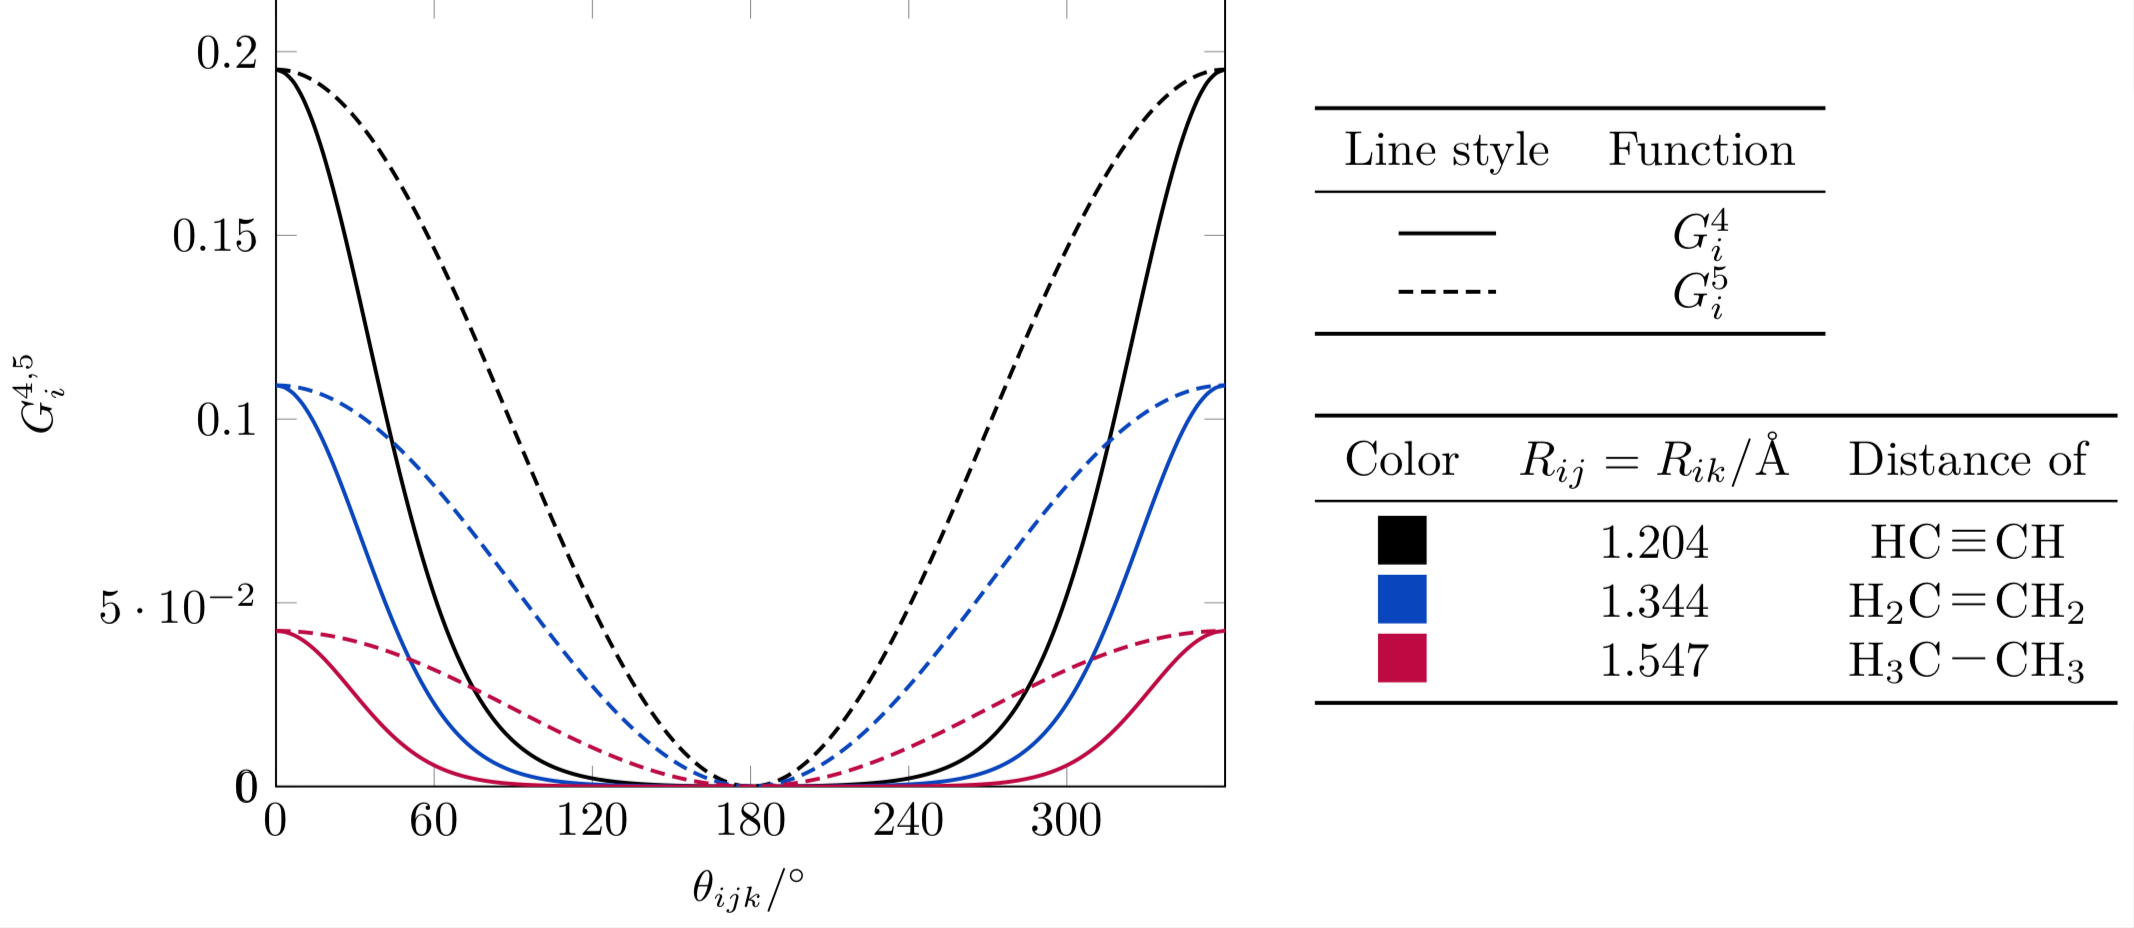

# The ANAKIN-ME (ANI) family of NNPs

The *Accurate NeurAl networK engINe for Molecular Energies* family is a collection of NNPs that builds upon the original Behler-Parrinello formulation of NNPs.

Whereas the original NNP formulation is oriented towards MD simulations of single-element systems, the ANI potentials are also capable of predicting the energy of discrete organic molecular systems, and is compatible with systems of diverse atoms: H, C, N, O, and later S, F, and Cl.

Currently, the ANI family of NNPs is composed of:
* ANI-1, https://doi.org/10.1039/C6SC05720A

This is the original ANI formulation. This model makes predictions that are quite faithful to the original training data, calculated with the ωB97X/6-31G* level of theory at a fraction of the computational cost.

* ANI-1x, https://doi.org/10.1063/1.5023802

This model expands upon the normal-mode sampling (NMS) technique that was used to build the original ANI-1 dataset. Seeing as it can leave some parts of the chemical space under-represented, such as the dihedral-torsion space, enhanced chemical sampling techniques are deployed for the creation of a new dataset upon which the ANI-1x model was trained.

Additionally, the Query-By-Commitee (QBC) method is used to obtain additional structures selectively, whenever there is disagreement in the molecule's energies between the multiple models that are being trained at once.

This enhanced sampling makes for a better trained model: ANI-1x vastly outperforms ANI-1 after being trained to only 25% of the original data.

* ANI-1ccx, https://doi.org/10.1038/s41467-019-10827-4

This model took ANI-1x as its starting point. The model was retrained, via transfer learning, to a high-quality (CCSD(T)/CBS) dataset.

The trained model can outperform not only the ANI-1x NNP, but also B3LYP, B3LYP-D3, MP2/6-311+G*, among others.

* ANI-2x, https://doi.org/10.1021/acs.jctc.0c00121

This NNP expands the capabilities of the original ANI potentials. It adds two halogens and sulfur to the training dataset. As such, it is compatible with the atoms H, C, N, O, F, Cl, S.

Therefore, this NNP is compatible with the vast majority of drug-like molecules.

## The ANI symmetry functions

One of the key differences between the original BP formulation and ANI's is the way the symm

The symmetry functions at the heart of the ANI NNPs exhibit a few differences to those in the original NNP formulation.

The radial function is an unchanged $G_i^2$:
$$
G_i^2 = \sum_{\substack{j = 1 \\ j \neq i}}^{n_{\text{a}}} \exp[ -\eta(R_{ij} - R_{\text{s}})^2] \cdot f_{\text{c}}(R_{ij})
$$
on the other hand, its angular function is a modified version of $G_i^5$. ANI's angular function is denoted $G_m^{\text{A}_{\text{mod}}}$

$$
G_i^5 = 2^{1-\zeta} \sum_{\substack{j=1 \\ j \neq i}}^{n_{\text{a}}} \sum_{\begin{subarray}{l}
k=1 \\ k \neq i \\ k \neq j
\end{subarray}}^{n_{\text{a}}} (1 + \lambda \cos \theta_{ijk})^\zeta \cdot \exp[-\eta(R_{ij}^2 + R_{ik}^2)] \cdot f_{\text{c}}(R_{ij}) \cdot f_{\text{c}}(R_{ik})
$$

$$
G_m^{\text{A}_{\text{mod}}} = 2^{1-\zeta} \sum_{\substack{j=1 \\ j \neq i}}^{n_{\text{a}}} \sum_{\begin{subarray}{l}
k=1 \\ k \neq i \\ k \neq j
\end{subarray}}
^{n_{\text{a}}} [1 + \lambda \cos (\theta_{ijk} - \theta_{\text{s}})]^\zeta \cdot \exp\left[-\eta \left(\frac{R_{ij} + R_{ik}}{2} - R_{\text{s}}\right)^{2}\right] \cdot f_{\text{c}}(R_{ij}) \cdot f_{\text{c}}(R_{ik})
$$

Note that the introduction of $\theta_{\text{s}}$ and $R_{\text{s}}$ means that the function can be 'specialized' into probing a particular portion of the radial and angular space around the atom $i$.

## The ensemble of symmetry functions: Atomic Environment Vector

We've mentioned several times that an ensemble of radial and angular symmetry functions with different parameters can be used to obtain a detailed picture of what the environment of each atom looks like.

In ANI terms, this ensemble is called an *Atomic Environment Vector*, or AEV. This concept can be best explained with a picture. This is the figure 1 from the ANI paper on its pytorch implementation: https://doi.org/10.1021/acs.jcim.0c00451 .

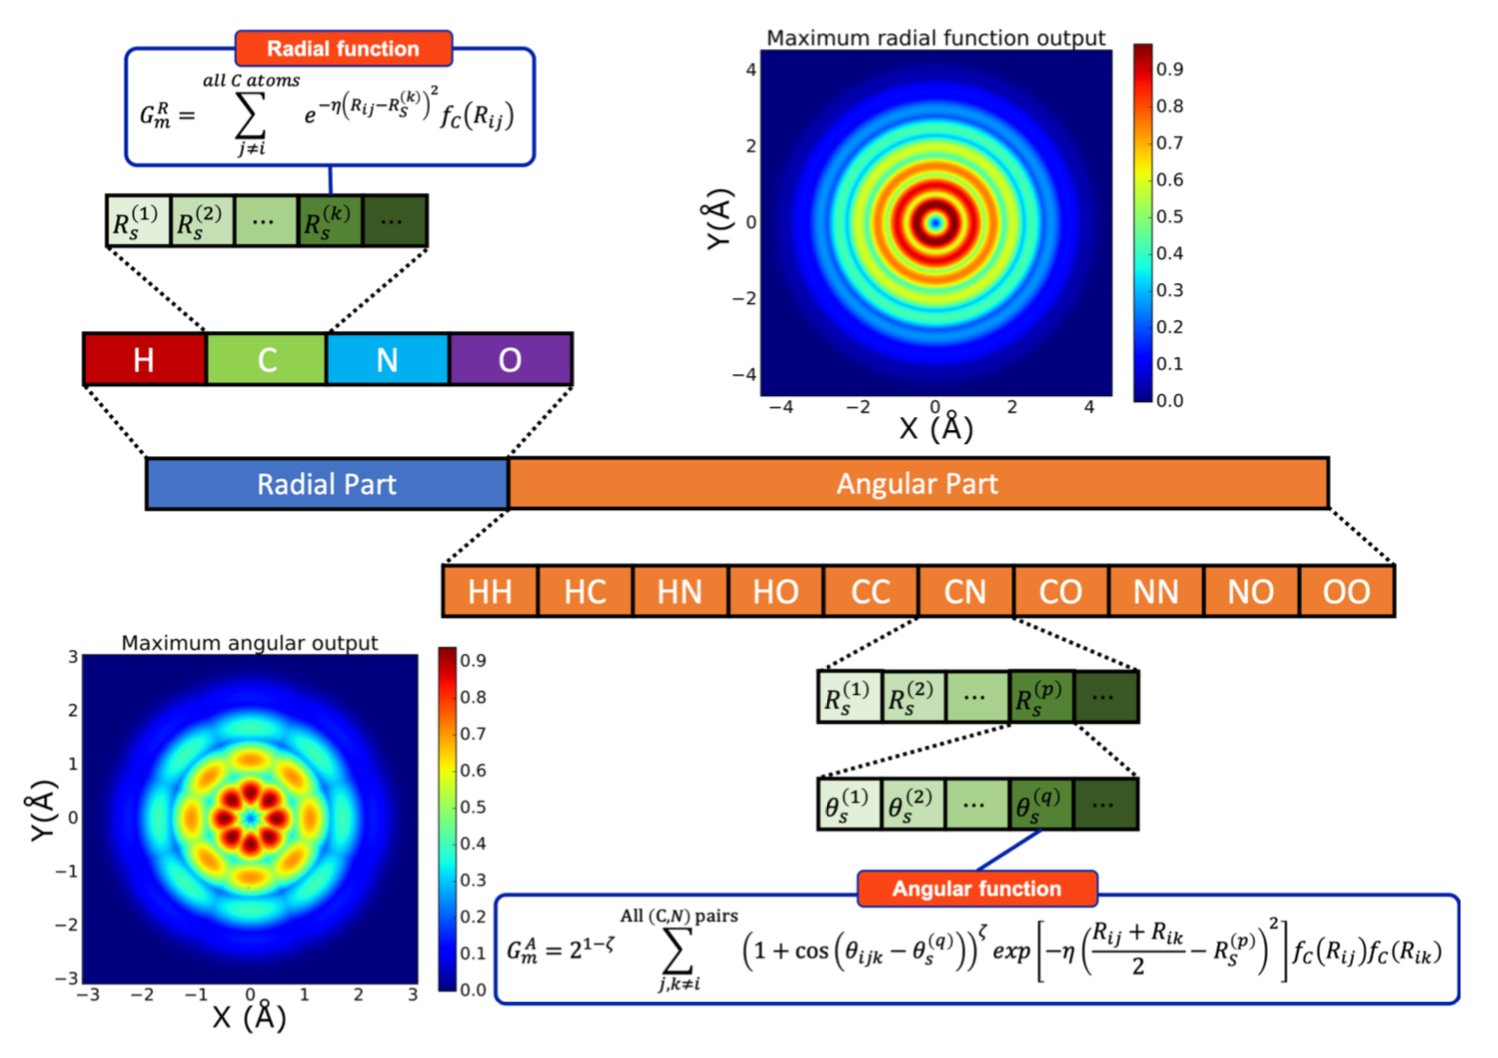

In brief, the AEV-description of an atom is obtained as follows:
1. An atom $i$ is selected. The rest of atoms are considered to be part of the *environment* of atom $i$.
2. The radial part of the AEV is constructed:
    * This section of the AEV probes the surrounding atoms separately, according to their type.
    * This means there is a block of functions that measure the radial environment between the atom $i$ and the molecule's hydrogens, then another that measures the environment between the atom $i$ and the molecule's carbons, and so on.
    * Each of these blocks has a series of functions $G_i^2$ with different values of $R_{\text{s}}$.
3. The angular part of the AEV is constructed:
    * If the atom types compatible with a given ANI model are (H, C, N, O), then there are $10$ possible triads that involve $i$ _and_ all the possible pairs of atoms in $i$'s environment. The angular portion of this block contains, thus, ten separate partitions, one for each possible triad.
    * In each of these partitions, a series of $G_i^5$ is calculated, each with a different pair of values for $(R_{\text{s}},\theta_{\text{s}})$.

The entirety of this vector (its radial and angular part together) constitutes the input that a neural network uses to calculate the energy of the atom $i$.

Once this process is repeated for all atoms in the molecule, the molecular energy can be obtained by summing all of the per-atom energies.

# An overview of the coordinates-AEV-energy process: a $C_s$ formaldehyde molecule

Consider the following drawing of a formaldehyde molecule. While the usual geometry of this molecule is $C_{2\text{v}}$ (the same as the water molecule), where the two C-H bonds are equivalent, in this drawing we displaced one of the hydrogens and painted it blue so that they become distinct.

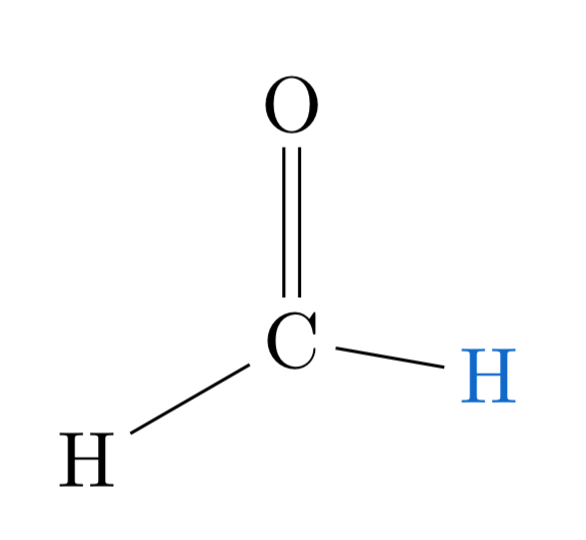

Following the AEV construction procedure outlined above, we can summarize the molecular-energy calculation process in the following picture:

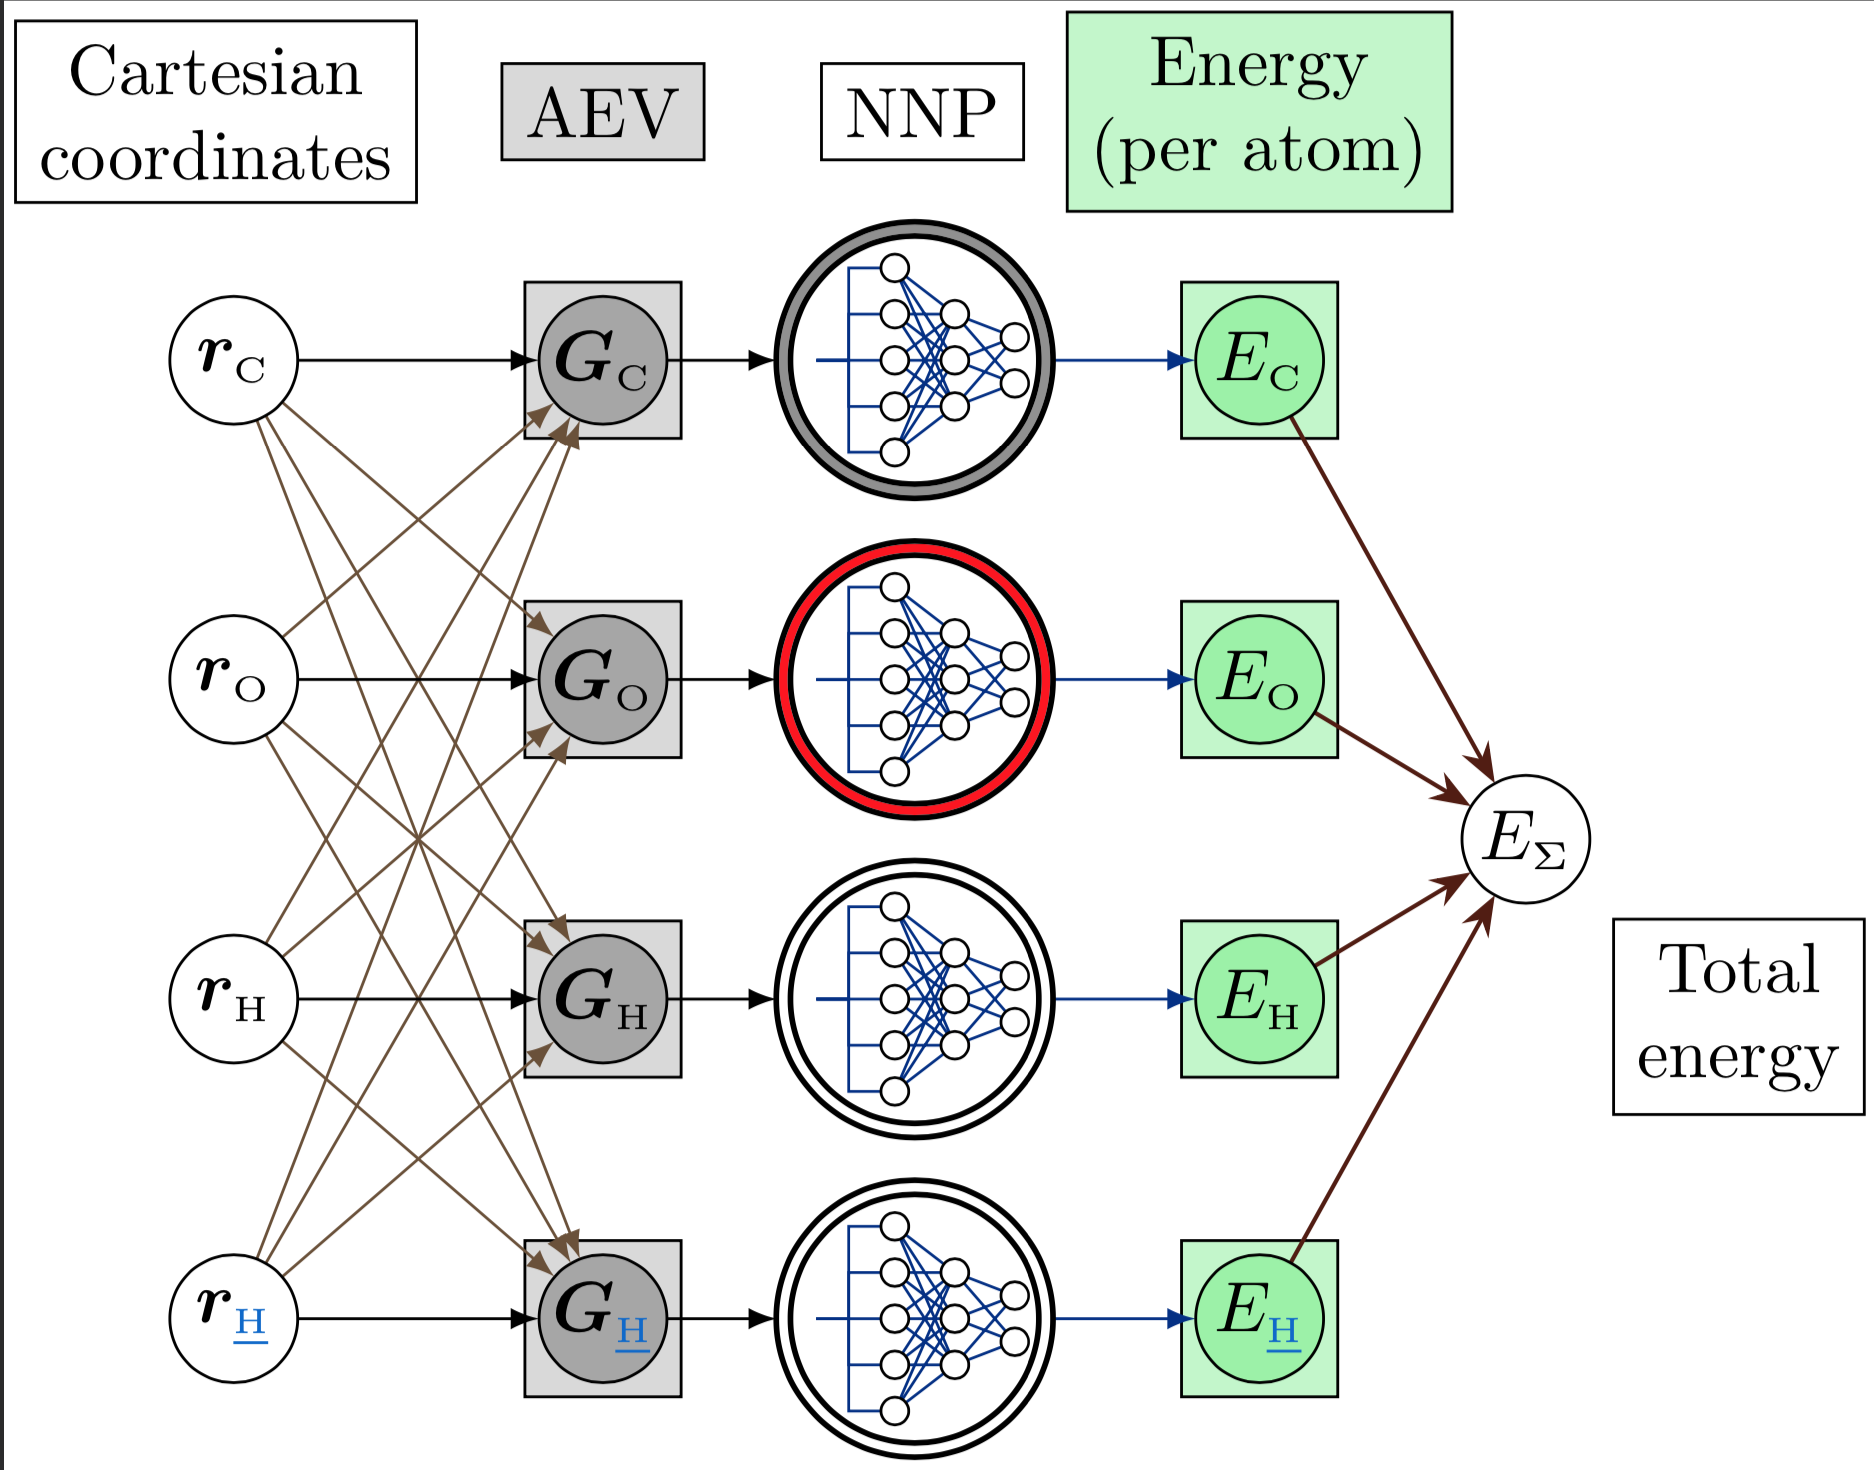

The process starts in the grey column:
1. The vector of $G$-functions, the AEV, is denoted by $\bf G$$_{\text{Sy}}$, where $\text{Sy}$ is the atomic symbol.
2. The first time around, we'll calculate the AEV of the atom $\text{C}$. Therefore, the other three atoms are considered to be the carbon's environment. This is denoted by the black (main atom) and light brown arrows (environment atom).
3. The AEV is calculated according to the radial and angular ensemble of symmetry functions.
4. The completed AEV acts as the _input layer_ of the respective neural network. The NN that calculates the atomic energies is different for each atom type; this is denoted by the color in the NNP's outer ring. Note that the NNP is the same for both hydrogens, or for all kinds of hydrogens in a molecule, no matter how different their chemical environments are.

This is one of ANI's biggest strenghts: some classical force fields (such as UFF) that need to distinguish elements such as carbon, nitrogen, or oxygen, according to the atom's hybridization or amount of bonds, so that the appropriate parameters can be loaded into a function for calculating the atom's energy.

On the other hand, ANI doesn't need this kind of preprocessing: the AEV of each atom is input directly, and the NN is trusted to be able to distinguish between all the possible atom environments, and calculate the atom's energy accordingly. This distinguishing capability is ensured through very thorough sampling techniques during training.

5. The NNP has a single output node: it contains the atom's energy.

6. Finally, the sum of the atomic energies results in the molecular energy according to the selected ANI model.